# Introduction
This notebook analyses the relationship of measures against COVID-19 (Coronavirus disease 2019) and the number of infected cases. The goal is to find measures that enable us to settle the situation more quickly.

We will use SIR-F model that is a customized ODE model derived from SIR model. To evaluate the effect of measures, parameter estimation of SIR-F will be applied to subsets of time series data in each country. Parameter change points will be determined by S-R trend analysis. The details will be explained in "Method" part.

#导言
这本笔记本分析2019冠状病毒疾病（CONVIDIs 2019）和感染病例数的关系。我们的目标是找到能够使我们更快解决局势的措施。
我们将使用SIR-F模型，它是从SIR模型派生的定制ODE模型。为了评估措施的效果，将对每个国家的时间序列数据子集进行SIR-F参数估计。参数变化点将通过S-R趋势分析确定。详细内容将在“方法”部分解释。

** To accerate open data science of COVID-19, I published the code as a Python library in [GitHub repository: CovsirPhy](https://github.com/lisphilar/covid19-sir) and PyPI (`pip install covsirphy --upgrade`). Documentation is [here](https://lisphilar.github.io/covid19-sir/). Please analyse your country's data with CovsirPhy and share your ideas via [GitHub issue page of CovsirPhy project](https://github.com/lisphilar/covid19-sir/issues).**

** 2019冠状病毒疾病数据公开科学，我在[GITHUB库：COVSIRPHY ]中发布了作为Python库的代码。https://github.com/lisphilar/covid19-sir)和PyPI（`pip install covsirphy--upgrade`）。文件在[这里](https://lisphilar.github.io/covid19-sir/). 请使用CovsirPhy分析您所在国家的数据，并通过[CovsirPhy项目的GitHub发布页面]分享您的想法(https://github.com/lisphilar/covid19-sir/issues).**

1. Preparation
   * [Dataset and tools](#1)
   * [Grouping by growth factor](#2)

2. Method
   * [SIR to SIR-F](#4)
   * [SIR-F with exposed/waiting cases](#5)
   * [Factors of model parameters](#6)
   * [S-R trend analysis](#10)

3. Scenario analysis
   * [Scenario in Italy](#7)
   * [Scenario in Japan](#8)

4. Remarks
   * [Conclusion](#9)
   * [Acknowledgement](#3)
   * [Change log](#11)

   1.准备
*[数据集和工具]（#1）
*[按生长因子分组]（#2）
2.方法
*[爵士对爵士-F]（#4）
*[SIR-F与暴露/等待案例]（#5）
*[模型参数因素]（#6）
*[S-R趋势分析]（#10）
3.情景分析
*[意大利情景]（#7）
*[日本情景]（#8）
4.评论
*[结论]（#9）
*[确认]（#3）
*[更改日志]（#11）

Note:  
"Infected" means the currently infected and confirmed cases.  
This can be calculated  as "Confirmed" - "Deaths" - "Recovered" in [COVID-19 Data Repository by CSSE at Johns Hopkins University](https://github.com/CSSEGISandData/COVID-19).

注:
“已感染”是指目前已感染和确诊的病例。
这可以计算为[约翰霍普金斯大学CSSE发布的新冠病毒-19数据存储库]中的“确认”-“死亡”-“恢复”(https://github.com/CSSEGISandData/COVID-19).

Citation:  
Please cite CovsirPhy library and this notebook as follows.

引用：
请引用CovsirPhy图书馆和本笔记本如下。

- CovsirPhy Development Team (2020-2021), CovsirPhy version [version number]: Python library for COVID-19 analysis with phase-dependent SIR-derived ODE models, https://github.com/lisphilar/covid19-sir
- Hirokazu Takaya (2020-2021), Kaggle Notebook, COVID-19 data with SIR model, https://www.kaggle.com/lisphilar/covid-19-data-with-sir-model

2019冠状病毒疾病发展小组（2020—2021），COVSIRPHY版本[版本号]：Python库，用于COVID-19分析，其具有依赖于相位的SIR衍生的ODE模型，https://github.com/lisphilar/covid19-sir
-2019冠状病毒疾病Hirokazu Takaya，Kaggle Notebook，COVID-19数据与SIR模型，https://www.kaggle.com/lisphilar/covid-19-data-with-sir-model

In [1]:
from datetime import datetime
time_format = "%d%b%Y %H:%M"
datetime.now().strftime(time_format)

'03Dec2021 10:36'

#### Updates
 * 13Feb2020-31Dec2020: (Please read [Change log](#11) subsection.)
 
 * 09Jan2021: Update with CovsirPhy v2.14.0
 * 17Jan2021: Update with CovsirPhy v2.15.0
 * 30Jan2021: Stop to use linelist data
 * 12Feb2021: Update with CovsirPhy v2.16.1
 * 14Feb2021: Update with CovsirPhy v2.16.2
 * 01Mar2021: Update with CovsirPhy v2.17.0
 * 20Mar2021: Add citation
 * 28Mar2021: Update with CovsirPhy v2.18.0
 * 11Apr2021: Update with CovsirPhy v2.19.0
 * 18Apr2021: Update with CovsirPhy v2.19.1
 * 19May2021: Update with CovsirPhy v2.20.0/2.20.1
 * 27May2021: Update with CovsirPhy v2.20.2
 * 10Jun2021: Update with CovsirPhy v2.20.3
 * 20Jun2021: Update with CovsirPhy v2.21.0
 * 31Jul2021: Update with CovsirPhy v2.22.0

# Dataset and tools<a id="1"></a>

## Package

### Package for SIR analysis
[CovsirPhy](https://github.com/lisphilar/covid19-sir) downloads the datasets and analyse it. Stable versions are registed to PyPI and development versions are in GutHub repository. We will install the latest development version here to test new features, but you can select stable versions for your analysis.

In [2]:
!python --version

Python 3.9.7


In [3]:
# Remove third-party typing package from Kaggle environment, if necessary (Python <3.7.9)
# https://lisphilar.github.io/covid19-sir/INSTALLATION.html
# !pip uninstall typing -y

In [4]:
# Development version in GitHub
!pip install --upgrade "git+https://github.com/lisphilar/covid19-sir.git#egg=covsirphy"
# Stable version in PyPI
# !pip install --upgrade covsirphy

  Cloning https://github.com/lisphilar/covid19-sir.git to c:\users\iot421\appdata\local\temp\pip-install-tdqvqzrm\covsirphy_351a8b7713d74eabab342a69f3166b84
  Running command git clone -q https://github.com/lisphilar/covid19-sir.git 'C:\Users\iot421\AppData\Local\Temp\pip-install-tdqvqzrm\covsirphy_351a8b7713d74eabab342a69f3166b84'
  ERROR: Error [WinError 2] 系统找不到指定的文件。 while executing command git clone -q https://github.com/lisphilar/covid19-sir.git 'C:\Users\iot421\AppData\Local\Temp\pip-install-tdqvqzrm\covsirphy_351a8b7713d74eabab342a69f3166b84'
ERROR: Cannot find command 'git' - do you have 'git' installed and in your PATH?


In [5]:
import covsirphy as cs
cs.__version__

ModuleNotFoundError: No module named 'covsirphy'

### General packages

In [6]:
!pip install openpyxl

     |████████████████████████████████| 242 kB 893 kB/s 


In [7]:
from collections import defaultdict
from datetime import timedelta
from dateutil.relativedelta import relativedelta
import functools
from IPython.display import display, Markdown
import math
import os
from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from matplotlib.ticker import ScalarFormatter
%matplotlib inline
import numpy as np
import pandas as pd
import dask.dataframe as dd
pd.plotting.register_matplotlib_converters()
import seaborn as sns
import scipy as sci
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import sympy as sym

In [8]:
# Ramdam
np.random.seed(123)
os.environ["PYTHONHASHSEED"] = "123"
# Matplotlib
plt.style.use("seaborn-ticks")
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["font.size"] = 11.0
plt.rcParams["figure.figsize"] = (9, 6)
# Pandas
pd.set_option("display.max_colwidth", 1000)

## Datasets
We will use both of Kaggle datasets and external datasets.

### Overview of datasets

#### Kaggle datasets
We will use the Kaggle datasets saved in "/kaggle/input" directory.

- [COVID-19 Prevention in Italy](https://www.kaggle.com/marcoferrante/covid19-prevention-in-italy): measures taken in Italy
- [Novel Corona Virus 2019 Dataset](https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset): line list of COVID-19

#### External data sources
There are many useful data sources to enhance our analysis.

- [COVID-19 Data Hub](https://covid19datahub.io/): The number of cases, populaton values, government responses (retrieved from [Oxford Covid-19 Government Response Tracker](https://github.com/OxCGRT/covid-policy-tracker))
- Linelist of COVID-19 (will be included in the near future)
- [Popuation Pyramid](https://data.worldbank.org/)
- [Our World In Data](https://github.com/owid/covid-19-data/tree/master/public/data): the number of tests, vaccinations, the number of people who received vacccinations
- [COVID-19 dataset in Japan](https://github.com/lisphilar/covid19-sir/tree/master/data): the number of cases in Japan, this is the same as [Kaggle: COVID-19 dataset in Japan](https://www.kaggle.com/lisphilar/covid19-dataset-in-japan)

In the previous versions, we used the following Kaggle datasets. Thank you for your great hard work, the authors!

- [Novel Corona Virus 2019 Dataset](https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset): the number of cases, linelist of COVID-19
- [covid19 global forecasting: locations population](https://www.kaggle.com/dgrechka/covid19-global-forecasting-locations-population/metadata): population values
- [Kaggle: Population Pyramid 2019](https://www.kaggle.com/hotessy/population-pyramid-2019): Population pyramid

##数据集
我们将同时使用Kaggle数据集和外部数据集。
###数据集概述
####卡格尔数据集
我们将使用保存在“/Kaggle/input”目录中的Kaggle数据集。
-[意大利的新冠病毒-19预防](https://www.kaggle.com/marcoferrante/covid19-prevention-in-italy)：在意大利采取的措施
-[新型电晕病毒2019数据集](https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset2019冠状病毒疾病的基因列表
####外部数据源
有许多有用的数据来源来加强我们的分析。
-[新冠病毒-19数据中心](https://covid19datahub.io/：案件数量、人口价值、政府反应（从牛津COVID-19政府反应跟踪器中检索）https://github.com/OxCGRT/covid-policy-tracker))
COVID-19的Linelist（将在不久的将来）
-[人口金字塔](https://data.worldbank.org/)
-[我们的数据世界](https://github.com/owid/covid-19-data/tree/master/public/data)：检测次数、接种次数、接种疫苗的人数
-[日本新冠病毒-19数据集](https://github.com/lisphilar/covid19-sir/tree/master/data（2019冠状病毒疾病）：日本的病例数与日本的KGOLE：COVID-19数据集相同（https://www.kaggle.com/lisphilar/covid19-dataset-in-japan)
在以前的版本中，我们使用了以下Kaggle数据集。感谢您的辛勤工作，作者们！
-[新型电晕病毒2019数据集](https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset2019冠状病毒疾病病例数
-[covid19全球预测：地点和人口](https://www.kaggle.com/dgrechka/covid19-global-forecasting-locations-population/metadata)：总体值
-[卡格尔：2019年人口金字塔](https://www.kaggle.com/hotessy/population-pyramid-2019)：人口金字塔

### The number of cases
Yes, the main dataset is for the number of COVID-19 cases. This will be retrieved from [COVID-19 Data Hub](https://covid19datahub.io/) (and [COVID-19 dataset in Japan](https://github.com/lisphilar/covid19-sir/tree/master/data) for Japan). To retrive this dataset, CovsirPhy uses `covid19dh` internally as discussed in [GitHub issue#87 of COVID-19 Data Hub](https://github.com/covid19datahub/COVID19/issues/87).

This dataset includes population values to calculate the number of "susceptible" cases.
"Susceptible" = "Total population" - "Confirmed" in SIR-F model (explained later!)

Citation:  
Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Journal of Open Source Software 5(51):2376, doi: 10.21105/joss.02376.
Hirokazu Takaya (2020-2021), COVID-19 dataset in Japan, GitHub repository, https://github.com/lisphilar/covid19-sir/data/japan

In [9]:
# Create instance of covsirphy.DataLoader class
data_loader = cs.DataLoader(directory="kaggle/input")
# Retrieve the dataset of the number of COVID-19 cases
# Kaggle platform: covid19dh.csv will be saved in /output/kaggle/working/input
# Local env: covid19dh.csv will be saved in kaggle/input
#2019冠状病毒疾病的数据集
#Kaggle平台：covid19dh.csv将保存在/output/Kaggle/working/input中
#本地环境：covid19dh.csv将保存在kaggle/input中
# JHU一般指约翰斯·霍普金斯大学。
jhu_data = data_loader.jhu()

# 从日本检索COVID-19数据集https://github.com/lisphilar/covid19-sir/data/japan
# 2019冠状病毒疾病数据集检索https://covid19datahub.io/
# 请设置verbose=2以查看详细的引用列表。
# 在数据中从我们的世界检索数据集https://github.com/owid/covid-19-data/
# 利用谷歌云平台2019冠状病毒疾病数据的检索https://github.com/GoogleCloudPlatform/covid-19-open-data

Retrieving COVID-19 dataset in Japan from https://github.com/lisphilar/covid19-sir/data/japan
Retrieving datasets from COVID-19 Data Hub https://covid19datahub.io/
	Please set verbose=2 to see the detailed citation list.
Retrieving datasets from Our World In Data https://github.com/owid/covid-19-data/
Retrieving datasets from COVID-19 Open Data by Google Cloud Platform https://github.com/GoogleCloudPlatform/covid-19-open-data


Cleaned dataset (of all countries) was saved in `jhu_data` and we can get the cleaned dataset as a `pandas.DataFrame`.
清理后的数据集（所有国家的）保存在“jhu_数据”中，我们可以将清理后的数据集作为“pandas.DataFrame”获取。

In [10]:
jhu_data.cleaned().tail()

,Date,ISO3,Country,Province,Confirmed,Infected,Fatal,Recovered,Population
948566,2021-10-23,ZWE,Zimbabwe,-,132588,44931,4663,82994,14439018
948567,2021-10-24,ZWE,Zimbabwe,-,132651,44988,4669,82994,14439018
948568,2021-10-25,ZWE,Zimbabwe,-,132688,45021,4673,82994,14439018
948569,2021-10-26,ZWE,Zimbabwe,-,132724,45056,4674,82994,14439018
948570,2021-10-27,ZWE,Zimbabwe,-,132808,45139,4675,82994,14439018


We can subset records with country name (and province name).

In [11]:
jhu_data.subset("Japan", province=None).tail()

,Date,Confirmed,Infected,Fatal,Recovered,Susceptible
626,2021-10-24,1716692,5482,18191,1693019,124812408
627,2021-10-25,1716010,4819,18206,1692985,124813090
628,2021-10-26,1716322,4727,18221,1693374,124812778
629,2021-10-27,1716634,4396,18228,1694010,124812466
630,2021-10-28,1716908,4661,18237,1694010,124812192


In [12]:
df = jhu_data.cleaned()
jhu_first_date, jhu_last_date = df["Date"].min(), df["Date"].max()
jhu_elapsed = (jhu_last_date - jhu_first_date).days
print(f"{jhu_elapsed} days have passed from the date of the first record.")

666 days have passed from the date of the first record.


### Population pyramid
We will use population pyramid to estimate the number of days go out in average.
###人口金字塔
我们将使用人口金字塔来估计平均外出天数。

In [13]:
pyramid_data = data_loader.pyramid()

### The number of days go out (template data)
**As a comment of this notebook, @marcoferrante estimated the number of days persons of each age group usually go out. Thank you for your kind cooperation!!**
###外出天数（模板数据）
**作为本笔记本的评论，@marcoferrante估计了每个年龄组的人通常外出的天数。谢谢你的合作**

In [14]:
# @marcoferrante estimation
_period_of_life_list = [
    "nursery", "nursery school", "elementary school", "middle school",
    "high school", "university/work", "work", "work", "work", "work",
    "retired", "retired", "retired"
]
df = pd.DataFrame(
    {
        "Age_first": [0, 3, 6, 11, 14, 19, 26, 36, 46, 56, 66, 76, 86],
        "Age_last": [2, 5, 10, 13, 18, 25, 35, 45, 55, 65, 75, 85, 95],
        "Period_of_life": _period_of_life_list,
        "Days": [3, 5, 6, 6, 7, 7, 6, 5, 5, 5, 4, 3, 2]
    }
)
# Adjustment by author
df["Types"] = df["Period_of_life"].replace(
    {
        "nursery": "school",
        "nursery school": "school",
        "elementary school": "school",
        "middle school": "school",
        "high school": "school",
        "university/work": "school/work"
    }
)
df["School"] = df[["Types", "Days"]].apply(lambda x: x[1] if "school" in x[0] else 0, axis=1)
df["Office"] = df[["Types", "Days"]].apply(lambda x: x[1] if "work" in x[0] else 0, axis=1)
df["Others"] = df["Days"] - df[["School", "Office"]].sum(axis=1)
df.loc[df["Others"] < 0, "Others"] = 0
df.loc[df.index[1:5], "School"] -= 1
df.loc[df.index[1:5], "Others"] += 1
df.loc[df.index[5], ["School", "Office", "Others"]] = [3, 3, 1]
df[["School", "Office", "Others"]] = df[["Days", "School", "Office", "Others"]].apply(
    lambda x: x[1:] / sum(x[1:]) * x[0], axis=1
).astype(np.int64)
df.loc[df.index[6:10], "Others"] += 1
df = df.drop(["Days", "Types"], axis=1)
# Show dataset
_out_df = df.copy()
_out_df

,Age_first,Age_last,Period_of_life,School,Office,Others
0,0,2,nursery,3,0,0
1,3,5,nursery school,4,0,1
2,6,10,elementary school,5,0,1
3,11,13,middle school,5,0,1
4,14,18,high school,6,0,1
5,19,25,university/work,3,3,1
6,26,35,work,0,6,1
7,36,45,work,0,5,1
8,46,55,work,0,5,1
9,56,65,work,0,5,1


For each country, population pyramid data will be combined to the table. The columns with countriy names are the portion of the total population.
对于每个国家，人口金字塔数据将合并到表中。带有国家名称的列是总人口的一部分。

In [15]:
def go_out(country, pyramid_data=pyramid_data):
    """
    Return the estimated number of days people usually go out.
    Args:
        country (str): coutry name
        pyramid_data (covsirphy.PopulationPyramidData): pyramid dataset
    
    Returns:
        pandas.DataFrame
        返回人们通常外出的估计天数。
Args：
国家（str）：国家名称
金字塔数据（covsirphy.PopulationPyramidData）：金字塔数据集
返回：
数据帧
    """
    p_df = pyramid_data.subset(country)
    p_df["Cumsum"] = p_df["Population"].cumsum()
    df = pd.merge(_out_df, p_df, left_on="Age_last", right_on="Age", how="left")
    df["Population"] = df["Cumsum"].diff()
    df.loc[df.index[0], "Population"] = df.loc[df.index[0], "Cumsum"]
    df["Population"] = df["Population"].astype(np.int64)
    df["Portion"] = df["Population"] / df["Population"].sum()
    return df.drop(["Per_total", "Cumsum"], axis=1)

go_out("Italy")
# 部分 Portion

Retrieving population pyramid dataset (Italy) from https://data.worldbank.org/


,Age_first,Age_last,Period_of_life,School,Office,Others,Age,Population,Portion
0,0,2,nursery,3,0,0,2,1373871,0.025722
1,3,5,nursery school,4,0,1,5,1441955,0.026997
2,6,10,elementary school,5,0,1,10,2667055,0.049933
3,11,13,middle school,5,0,1,13,1688673,0.031616
4,14,18,high school,6,0,1,18,2829215,0.052969
5,19,25,university/work,3,3,1,25,4087599,0.076529
6,26,35,work,0,6,1,35,6521421,0.122096
7,36,45,work,0,5,1,45,7940871,0.148671
8,46,55,work,0,5,1,55,9560703,0.178998
9,56,65,work,0,5,1,65,8261046,0.154666


### COVID-19 Prevention in Italy
To understand why the parameters were changed in Italy, we will use this dataset in Italy scenario analysis.
意大利2019冠状病毒疾病防治
为了理解参数在意大利发生变化的原因，我们将在意大利情景分析中使用此数据集。

In [16]:
ita_action_raw = pd.read_excel(
    "/kaggle/input/covid19-prevention-in-italy/Dataset_Italy_COVID_19.xlsx",
    sheet_name="Foglio1"
)
ita_action_raw.head()
# 入境限制 	Restriction of entry

,Country,Region,Village,Start date,End Date,Action,Detail,Number of people,link
0,Italy,NaN,NaN,30-jan-2020,NaN,Restriction of entry,All flights to and from China have been suspended,NaN,http://www.governo.it/it/approfondimento/coronavirus/13968
1,Italy,NaN,NaN,03-feb-2020,NaN,Leave from epidemic area,Return of people present in countries at risk and return of foreign citizens to the countries of origin exposed to the risk,NaN,http://www.governo.it/it/approfondimento/coronavirus/13969
2,Italy,NaN,NaN,06-feb-2020,NaN,Control in the Airport,Airport monitoring and control for domestic and international flights,62000,http://www.governo.it/it/approfondimento/coronavirus/13970
3,Italy,NaN,NaN,21-feb-2020,21-feb-2020,Quaranteene,"Mandatory quarantine isolation for close contacts with a positive cases, and provides active surveillance with fiduciary home permanence for those who have been in risk areas in the last 14 days",NaN,http://www.governo.it/it/approfondimento/coronavirus/13971
4,Italy,"Lombardia,Veneto","Vo’ Euganeo (Veneto) e Codogno, Castiglione d’Adda, Casalpusterlengo, Fombio, Maleo, Somaglia, Bertonico, Terranova dei Passerini, Castelgerundo e San Fiorano (Lombardia)",23-feb-2020,NaN,containment and management the Italian infected areas,decree-law introducing urgent measures regarding the containment and management of the epidemiological emergency from COVID-2019.,53856‬,http://www.governo.it/it/approfondimento/coronavirus/13972


In [17]:
df = ita_action_raw.copy()
df = df.drop(["Country", "Village", "link"], axis=1)
df.columns = [col.capitalize().replace(" ", "_") for col in df.columns]
df["Start_date"] = pd.to_datetime(df["Start_date"])
df["End_date"] = pd.to_datetime(df["End_date"])
df["Region"] = df["Region"].fillna("-")
df["Number_of_people"] = df["Number_of_people"].fillna(-1)
ita_action_df = df.copy()
ita_action_df.tail()
# 加强对意大利感染地区的控制和管理  more containment and management the Italian infected areas

,Region,Start_date,End_date,Action,Detail,Number_of_people
7,"Emilia Romagna,Friuli Venezia Giulia, Lombardia, Veneto, Piemonte e Liguria,",2020-03-07,2020-03-07,more containment and management the Italian infected areas,"prohibit any movement in Lombardy and in fourteen provinces of Veneto, Emilia Romagna, Piedmont, Marche.",-1
8,-,2020-03-09,2020-05-04,lockdown,people must stay at home and go out only for food or work needs. Many activities are closed and only the essential ones remain open.,60483973
9,-,2020-03-19,NaT,Medicine sperimentation,"testing began on the drug Tocilizumab, a drug used against rheumatoid arthritis that has had beneficial effects against COVID-19 in China.",330
10,-,2020-03-20,NaT,task force,create a task force of doctors from all over Italy to be able to send to the territories with the greatest health problems.,-1
11,-,2020-04-14,NaT,open some businesses,"Reopening of some production activities, newsagents, baby clothing stores, freelancers.",-1


## Visualize total data
Visualize the total velue of the number of cases in all countries.
##可视化总数据
想象所有国家的病例总数。

In [18]:
data_cols = ["Infected", "Fatal", "Recovered"]
rate_cols = ["Fatal per Confirmed", "Recovered per Confirmed", "Fatal per (Fatal or Recovered)"]

In [19]:
total_df = jhu_data.total()
total_df = total_df.loc[total_df.index <= jhu_last_date, :]
total_df.tail()

,Confirmed,Infected,Fatal,Recovered,Fatal per Confirmed,Recovered per Confirmed,Fatal per (Fatal or Recovered)
Date,,,,,,,
2021-10-24,241549227,90997938,4936135,145615154,0.020435,0.602838,0.032787
2021-10-25,241937544,91343218,4942535,145651791,0.020429,0.602022,0.032820
2021-10-26,242314232,91671720,4949873,145692639,0.020427,0.601255,0.032858
2021-10-27,242691153,91986988,4958541,145745624,0.020431,0.600540,0.032902
2021-10-28,60063770,8963249,971341,50129180,0.016172,0.834599,0.019008


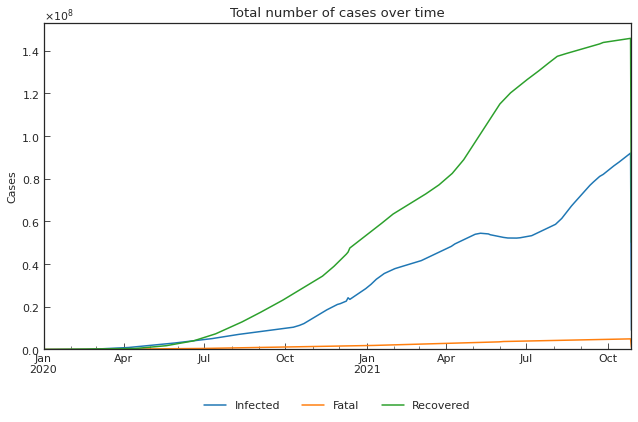

In [20]:
cs.line_plot(total_df[data_cols], "Total number of cases over time")

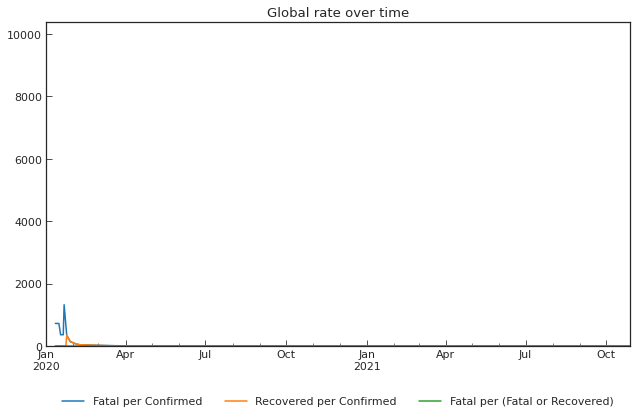

In [21]:
cs.line_plot(total_df[rate_cols], "Global rate over time", ylabel="", math_scale=False)

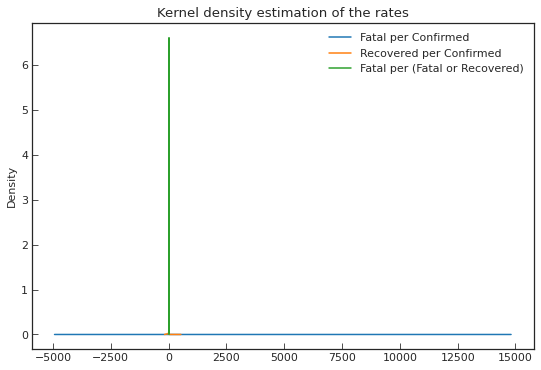

In [22]:
total_df[rate_cols].plot.kde()
plt.title("Kernel density estimation of the rates")
plt.show()

In [23]:
total_df[rate_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Fatal per Confirmed,657.0,30.786001,396.545678,0.015010,0.021223,0.022239,0.043821,9873.0
Recovered per Confirmed,657.0,4.301587,24.351176,0.000000,0.600540,0.627617,0.671871,352.0
Fatal per (Fatal or Recovered),657.0,0.102106,0.171316,0.009694,0.032072,0.034623,0.073760,1.0


# Grouping by growth factor<a id="2"></a>
The number of confirmed cases is increasing in many countries, but there are two of countries. In a first-type country, growth factor is larger than 1 and the number of cases is rapidly increasing. In a second-type country, growth factor is less than 1.

#按生长因子分组<a id=“2”></a>
在许多国家，确诊病例的数量正在增加，但有两个国家。在第一类国家，增长系数大于1，病例数量迅速增加。在第二类国家，增长系数小于1。

## Calculate growth factor
Where $C$ is the number of confirmed cases,  
$$\mathrm{Growth\ Factor} = \cfrac{\Delta \mathrm{C}_{n}}{\Delta \mathrm{C}_{n-1}}$$

##计算生长因子
其中$C$为确诊病例数，
$$\mathrm{Growth\Factor}=\cfrac{\Delta\mathrm{C}{n}{\Delta\mathrm{C}{n-1}$$

In [24]:
covid_df = jhu_data.cleaned()
df = covid_df.pivot_table(
    index="Date", columns="Country", values="Confirmed", aggfunc="sum"
).fillna(method="ffill").fillna(0)
# Growth factor: (delta Number_n) / (delta Number_n)
df = df.diff() / df.diff().shift(freq="D")
df = df.replace(np.inf, np.nan).fillna(1.0)
# Rolling mean (window: 7 days)
df = df.rolling(7).mean().dropna().loc[:covid_df["Date"].max(), :]
# round: 0.01
growth_value_df = df.round(2)
# 四舍五入？
growth_value_df.tail()

Country,Afghanistan,Albania,Algeria,American Samoa,Andorra,Angola,Anguilla,Antigua and Barbuda,Argentina,Armenia,...,Uzbekistan,Vanuatu,Venezuela,Vietnam,"Virgin Islands, British","Virgin Islands, U.S.",Wallis and Futuna,Yemen,Zambia,Zimbabwe
Date,,,,,,,,,,,,,,,,,,,,,
2021-10-11,1.23,0.83,0.97,1.0,0.91,0.85,0.71,1.55,0.92,1.04,...,1.00,1.0,0.91,0.95,0.86,0.65,1.0,1.12,1.17,1.38
2021-10-12,1.46,1.05,0.96,1.0,0.90,0.86,0.71,1.55,1.11,1.05,...,1.04,1.0,0.77,0.95,0.86,0.65,1.0,1.12,1.76,1.49
2021-10-13,1.06,1.10,0.99,1.0,0.58,1.01,0.71,1.25,1.13,1.06,...,0.98,1.0,0.84,0.98,0.86,0.65,1.0,1.24,1.55,1.16
2021-10-14,1.24,1.11,1.00,1.0,0.78,1.02,0.57,1.10,1.16,1.08,...,0.95,1.0,1.01,1.01,1.00,0.46,1.0,1.28,1.64,1.32
2021-10-15,1.20,1.11,0.99,1.0,0.82,1.06,0.57,1.38,1.20,1.11,...,1.02,1.0,0.93,0.98,1.00,0.57,1.0,1.25,1.84,1.07


## Grouping countires based on growth factor
* Outbreaking: growth factor $>$ 1 for the last 7 days
* Stopping: growth factor $<$ 1 for the last 7 days
* At a crossroad: the others

## 基于增长因子的国家分组
* 爆发：过去7天的增长因子 $>$ 1
* 停止：过去7天的生长因子 $<$ 1
* 在十字路口：其他

In [25]:
df = growth_value_df.copy()
df = df.iloc[-7:, :].T
day_cols = df.columns.strftime("%d%b%Y")
df.columns = day_cols
last_date = day_cols[-1]
# Grouping
more_col, less_col = "GF > 1 [straight days]", "GF < 1 [straight days]"
df[more_col] = (growth_value_df > 1).iloc[::-1].cumprod().sum(axis=0)
df[less_col] = (growth_value_df < 1).iloc[::-1].cumprod().sum(axis=0)
df["Group"] = df[[more_col, less_col]].apply(
    lambda x: "Outbreaking" if x[0] >= 7 else "Stopping" if x[1] >= 7 else "Crossroad",
    axis=1
)
# Sorting
df = df.loc[:, ["Group", more_col, less_col, *day_cols]]
df = df.sort_values(["Group", more_col, less_col], ascending=False)
growth_df = df.copy()
growth_df.head()

Date,Group,GF > 1 [straight days],GF < 1 [straight days],09Oct2021,10Oct2021,11Oct2021,12Oct2021,13Oct2021,14Oct2021,15Oct2021
Country,,,,,,,,,,
Costa Rica,Stopping,0,339,0.76,0.76,0.76,0.78,0.75,0.73,0.75
Botswana,Stopping,0,307,0.71,0.71,0.71,0.57,0.71,0.71,0.71
Equatorial Guinea,Stopping,0,134,0.71,0.71,0.71,0.71,0.71,0.57,0.71
Bermuda,Stopping,0,108,0.43,0.57,0.57,0.71,0.57,0.71,0.57
Gabon,Stopping,0,94,0.71,0.57,0.57,0.57,0.57,0.71,0.66


In [26]:
df = pd.merge(covid_df, growth_df["Group"].reset_index(), on="Country")
covid_df = df.loc[:, ["Date", "Group", *covid_df.columns[1:]]]
covid_df.tail()

,Date,Group,ISO3,Country,Province,Confirmed,Infected,Fatal,Recovered,Population
948566,2021-10-23,Outbreaking,ZWE,Zimbabwe,-,132588,44931,4663,82994,14439018
948567,2021-10-24,Outbreaking,ZWE,Zimbabwe,-,132651,44988,4669,82994,14439018
948568,2021-10-25,Outbreaking,ZWE,Zimbabwe,-,132688,45021,4673,82994,14439018
948569,2021-10-26,Outbreaking,ZWE,Zimbabwe,-,132724,45056,4674,82994,14439018
948570,2021-10-27,Outbreaking,ZWE,Zimbabwe,-,132808,45139,4675,82994,14439018


## Group 1: Outbreaking, growth factor $>$ 1 for the last 7 days

In [27]:
df = growth_df.loc[growth_df["Group"] == "Outbreaking", :]
", ".join(df.index.tolist()) + "."

'Spain, French Guiana, Slovenia, Belgium, Guadeloupe, Réunion, United States, Croatia, Poland, Greece, Lithuania, Switzerland, Martinique, Slovakia, Guatemala, Romania, Czech Republic, Georgia, Latvia, Bulgaria, Germany, Mayotte, Gibraltar, Mozambique, Ukraine, Curacao, Sao Tome and Principe, Portugal, Estonia, Zambia, Morocco, Russia, Burkina Faso, Dominican Republic, Chile, Kosovo, Lebanon, New Zealand, Senegal, Timor-Leste, Denmark, Armenia, France, Jamaica, Austria, Egypt, Jordan, Netherlands, Peru, Antigua and Barbuda, United Kingdom, Dominica, Kyrgyzstan, Sudan, Uruguay, Ireland, Taiwan, Italy, Liechtenstein, Uganda, Zimbabwe, Afghanistan, Cambodia, South Africa.'

In [28]:
growth_df.loc[growth_df["Group"] == "Outbreaking", :].head()

Date,Group,GF > 1 [straight days],GF < 1 [straight days],09Oct2021,10Oct2021,11Oct2021,12Oct2021,13Oct2021,14Oct2021,15Oct2021
Country,,,,,,,,,,
Spain,Outbreaking,388,0,1.98,1.96,2.26,2.19,2.85,2.85,2.84
French Guiana,Outbreaking,173,0,3.19,3.19,2.99,2.97,2.97,3.00,2.99
Slovenia,Outbreaking,163,0,1.28,1.26,1.47,1.47,1.48,1.50,1.54
Belgium,Outbreaking,130,0,1.31,1.31,1.40,1.41,1.40,1.42,1.43
Guadeloupe,Outbreaking,130,0,1.92,1.95,1.20,1.27,1.20,1.29,1.34


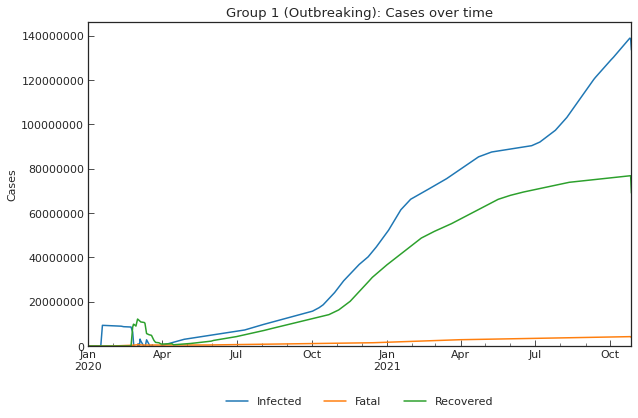

In [29]:
df = covid_df.loc[covid_df["Group"] == "Outbreaking", ["Date", *data_cols]]
df = df.groupby("Date").sum()
df = df.iloc[:-1, :]
if not df.empty:
    cs.line_plot(df, "Group 1 (Outbreaking): Cases over time", y_integer=True)
    df.tail()

## Group 2: Stopping, growth factor $<$ 1 for the last 7 days

In [30]:
df = growth_df.loc[growth_df["Group"] == "Stopping", :]
", ".join(df.index.tolist()) + "."

'Costa Rica, Botswana, Equatorial Guinea, Bermuda, Gabon, Luxembourg, Northern Mariana Islands, Oman, Libya, Bosnia and Herzegovina, Ecuador, Bahamas, Somalia, Belize, Nicaragua, Guam, Hungary, Anguilla, United Arab Emirates, Mauritius, Montserrat, Bangladesh, Iceland, Papua New Guinea, Seychelles, Malaysia, Monaco, Republic of the Congo, Burundi, Cuba, Grenada, Philippines, Virgin Islands, U.S., Benin, Cameroon, Cyprus, Gambia, Tanzania, Faroe Islands, Bolivia, Central African Republic, Finland, Honduras, Paraguay, Cayman Islands, Guyana, El Salvador, Falkland Islands (Malvinas), French Polynesia, India, Israel, South Korea, Chad, Andorra, Bonaire, Sint Eustatius and Saba, Haiti, San Marino, Sint Maarten.'

In [31]:
growth_df.loc[growth_df["Group"] == "Stopping", :].head()

Date,Group,GF > 1 [straight days],GF < 1 [straight days],09Oct2021,10Oct2021,11Oct2021,12Oct2021,13Oct2021,14Oct2021,15Oct2021
Country,,,,,,,,,,
Costa Rica,Stopping,0,339,0.76,0.76,0.76,0.78,0.75,0.73,0.75
Botswana,Stopping,0,307,0.71,0.71,0.71,0.57,0.71,0.71,0.71
Equatorial Guinea,Stopping,0,134,0.71,0.71,0.71,0.71,0.71,0.57,0.71
Bermuda,Stopping,0,108,0.43,0.57,0.57,0.71,0.57,0.71,0.57
Gabon,Stopping,0,94,0.71,0.57,0.57,0.57,0.57,0.71,0.66


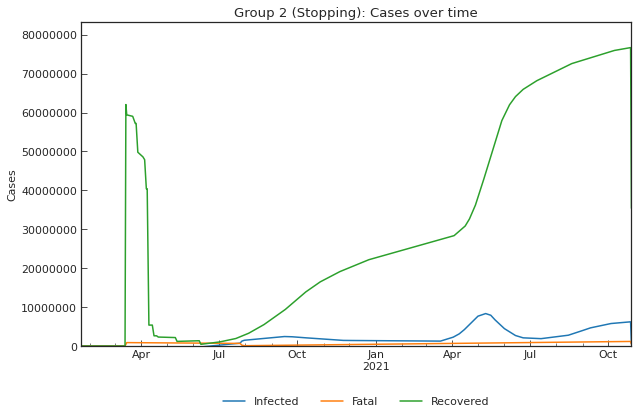

In [32]:
df = covid_df.loc[covid_df["Group"] == "Stopping", ["Date", *data_cols]].groupby("Date").sum()
if not df.empty:
    cs.line_plot(df, "Group 2 (Stopping): Cases over time", y_integer=True)
    df.tail()

## Group 3: At a crossroad, the others

In [33]:
df = growth_df.loc[growth_df["Group"] == "Crossroad", :]
", ".join(df.index.tolist()) + "."

"Brunei, Iran, Yemen, Democratic Republic of the Congo, Sweden, Albania, Argentina, Barbados, Comoros, Cote d'Ivoire, Indonesia, Iraq, Japan, Lesotho, Malawi, Maldives, Malta, Mexico, Moldova, Montenegro, New Caledonia, Norway, Suriname, Swaziland, Tunisia, Angola, Australia, Belarus, Isle of Man, Kenya, Mali, Mauritania, Nigeria, North Macedonia, Puerto Rico, Saudi Arabia, South Sudan, Azerbaijan, Brazil, Guinea, Pakistan, Syria, Cape Verde, Colombia, Ethiopia, Guinea-Bissau, Rwanda, Serbia, Singapore, Togo, Trinidad and Tobago, Uzbekistan, Djibouti, Canada, Aruba, Eritrea, Fiji, Liberia, Nepal, Palestine, Saint Kitts and Nevis, Bahrain, Bhutan, Kuwait, Namibia, Niger, Panama, Saint Lucia, Saint Vincent and the Grenadines, Algeria, Greenland, Laos, Madagascar, Mongolia, Myanmar, Palau, Sri Lanka, Thailand, Turks and Caicos Islands, Venezuela, Vietnam, American Samoa, Bonaire Sint Eustatius and Saba, British Virgin Islands, Cabo Verde, Cook Islands, Czechia, Democratic Republic of Cong

In [34]:
growth_df.loc[growth_df["Group"] == "Crossroad", :].head()

Date,Group,GF > 1 [straight days],GF < 1 [straight days],09Oct2021,10Oct2021,11Oct2021,12Oct2021,13Oct2021,14Oct2021,15Oct2021
Country,,,,,,,,,,
Brunei,Crossroad,6,0,0.93,1.19,1.12,1.32,1.30,1.27,1.38
Iran,Crossroad,6,0,0.98,1.01,1.01,1.03,1.04,1.03,1.05
Yemen,Crossroad,6,0,0.78,1.06,1.12,1.12,1.24,1.28,1.25
Democratic Republic of the Congo,Crossroad,5,0,0.57,0.57,3.17,3.17,3.17,3.17,3.17
Sweden,Crossroad,5,0,0.64,0.72,18.42,18.44,18.41,18.40,18.41


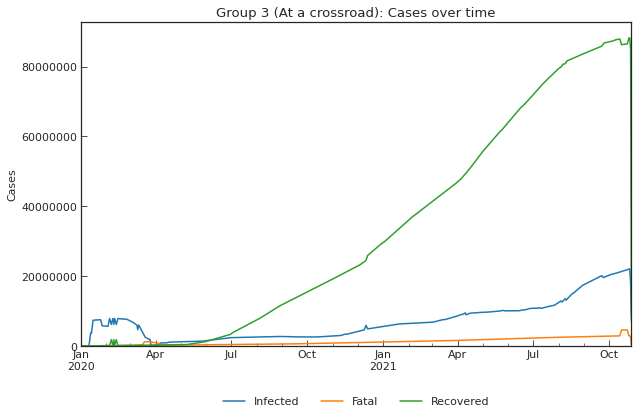

,Infected,Fatal,Recovered
Date,,,
2021-10-24,21951892,2946205,88162319
2021-10-25,22025187,2948169,88175078
2021-10-26,22098140,2950000,88202913
2021-10-27,18008783,2598925,84829104
2021-10-28,7083620,265877,9302512


In [35]:
df = covid_df.loc[covid_df["Group"] == "Crossroad", ["Date", *data_cols]].groupby("Date").sum()
cs.line_plot(df, "Group 3 (At a crossroad): Cases over time", y_integer=True)
df.tail()

# SIR to SIR-F<a id="4"></a>
In this section, we will create a customized mathematical model derived from SIR model.

#安全气囊系统至安全气囊系统-F<a id=“4”></a>
在本节中，我们将创建一个从SIR模型派生的自定义数学模型。

## SIR model
To understand the trend of infection, we will use mathematical epidemic model. Let's start discussion using the simplest model named SIR.

##先生模型
为了了解感染趋势，我们将使用数学流行病模型。让我们使用名为SIR的最简单模型开始讨论。

### What is SIR model?
SIR model is a simple mathematical model to understand outbreak of infectious diseases.  
[The SIR epidemic model - Learning Scientific Programming with Python](https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/)

###什么是SIR模型？
SIR模型是理解传染病爆发的简单数学模型。
[SIR流行病模型-使用Python学习科学编程](https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/)

* $\mathrm{S}$: Susceptible (= Population - Confirmed)
* $\mathrm{I}$: Infected (=Confirmed - Recovered - Fatal)
* $\mathrm{R}$: Recovered or Fatal (= Recovered + Fatal)
 
Note: THIS IS NOT THE GENERAL MODEL!  
Though R in SIR model is "Recovered and have immunity", I defined "R as Recovered or fatal". This is because mortality rate cannot be ignored in the real COVID-19 data.

注意：这不是一般型号！
虽然SIR模型中的R是“恢复并具有免疫力”，但我将“R定义为恢复或致命”。这是因为2019冠状病毒疾病的死亡率不能忽略。

Model:  
\begin{align*}
\mathrm{S} \overset{\beta I}{\longrightarrow} \mathrm{I} \overset{\gamma}{\longrightarrow} \mathrm{R}  \\
\end{align*}

$\beta$: Effective contact rate [1/min]  
$\gamma$: Recovery(+Mortality) rate [1/min]  

Ordinary Differential Equation (ODE):  
\begin{align*}
& \frac{\mathrm{d}S}{\mathrm{d}T}= - N^{-1}\beta S I  \\
& \frac{\mathrm{d}I}{\mathrm{d}T}= N^{-1}\beta S I - \gamma I  \\
& \frac{\mathrm{d}R}{\mathrm{d}T}= \gamma I  \\
\end{align*}

Where $N=S+I+R$ is the total population, $T$ is the elapsed time from the start date.

其中，$N=S+I+R$ 是总人口，$T$ 是从开始日期起经过的时间。

### Non-dimensional SIR model
To simplify the model, we will remove the units of the variables from ODE.

###无量纲SIR模型
为了简化模型，我们将从ODE中删除变量的单位。

Set $(S, I, R) = N \times (x, y, z)$ and $(T, \beta, \gamma) = (\tau t, \tau^{-1} \rho, \tau^{-1} \sigma)$.  

This results in the ODE  
\begin{align*}
& \frac{\mathrm{d}x}{\mathrm{d}t}= - \rho x y  \\
& \frac{\mathrm{d}y}{\mathrm{d}t}= \rho x y - \sigma y  \\
& \frac{\mathrm{d}z}{\mathrm{d}t}= \sigma y  \\
\end{align*}

Where $N$ is the total population and $\tau$ is a coefficient ([min], is an integer to simplify).  

其中，$N$ 是总人口，$\tau$ 是系数（[min]，是一个要简化的整数）。

The range of variables and parameters:  
变量和参数的范围：
\begin{align*}
& 0 \leq (x, y, z, \rho, \sigma) \leq 1  \\
\end{align*}
\begin{align*}
& 1\leq \tau \leq 1440  \\
\end{align*}

Basic reproduction number, Non-dimentional parameter, is defined as
基本复制数，非尺寸参数，定义为  
\begin{align*}
R_0 = \rho \sigma^{-1} = \beta \gamma^{-1}
\end{align*}

Estimated Mean Values of $R_0$:  
$R_0$ ("R naught") means "the average number of secondary infections caused by an infected host" ([Infection Modeling — Part 1](https://towardsdatascience.com/infection-modeling-part-1-87e74645568a)).  
(Secondary data: [Van den Driessche, P., & Watmough, J. (2002).](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6002118))  

$R_0$的估计平均值：
$R_0$（“R NOUT”）表示“受感染宿主引起的继发感染的平均数量”（[感染建模-第1部分](https://towardsdatascience.com/infection-modeling-part-1-87e74645568a)).  
（二级数据：[范登德里斯切，P.，和瓦特莫，J.（2002）。](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6002118))

2.06: Zika in South America, 2015-2016  
1.51: Ebola in Guinea, 2014  
1.33: H1N1 influenza in South Africa, 2009  
3.5 : SARS in 2002-2003  
1.68: H2N2 influenza in US, 1957  
3.8 : Fall wave of 1918 Spanish influenza in Genova  
1.5 : Spring wave of 1918 Spanish influenza in Genova  

2.06:2015-2016年南美寨卡
1.51:2014年几内亚埃博拉疫情
1.33:2009年南非H1N1流感
3.5:2002-2003年非典型肺炎
1.68:1957年美国H2N2流感
3.8：热那亚1918年西班牙流感的秋季浪潮
1.5：热那亚1918年西班牙流感春潮

When $x=\frac{1}{R_0}$, $\frac{\mathrm{d}y}{\mathrm{d}t}=0$.
<!--This means that the max value of confirmed ($=y+z$) is $1-\frac{1}{R_0}$.-->

### Example of non-dimensional SIR model
###无量纲SIR模型实例

In [36]:
# Set tau value and start date of records
# For explanation, the start date will be 01Jan2020
# This is not based on actual data

#设置记录的tau值和开始日期
#为便于解释，开始日期为2020年1月1日
#这不是基于实际数据
example_data = cs.ExampleData(tau=1440, start_date="01Jan2020")
# No records has been registered
example_data.cleaned()

,Date,Country,Province,Confirmed,Infected,Fatal,Recovered


In [37]:
# Model name
print(cs.SIR.NAME)
# Example parameter values
pprint(cs.SIR.EXAMPLE, compact=True)

SIR
{'param_dict': {'rho': 0.2, 'sigma': 0.075},
 'population': 1000000,
 'step_n': 180,
 'y0_dict': {'Fatal or Recovered': 0, 'Infected': 1000, 'Susceptible': 999000}}


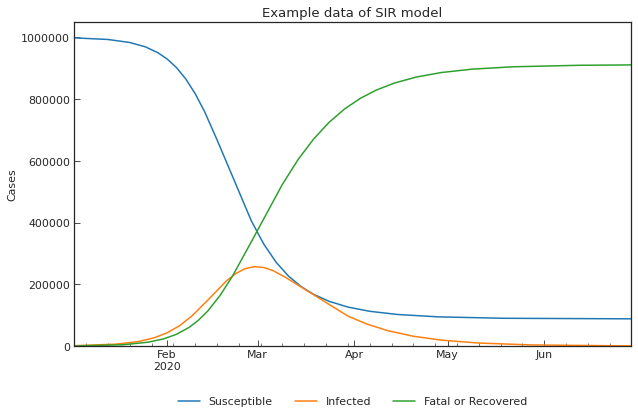

In [38]:
model = cs.SIR
area = {"country": "Full", "province": model.NAME}
# Add records with SIR model
example_data.add(model, **area)
# Records with model variables
df = example_data.specialized(model, **area)
cs.line_plot(
    df.set_index("Date"),
    title=f"Example data of {model.NAME} model",
    y_integer=True
)
# susceptible 易受影响

There is an inflection point of y (the number of currentry infected cases per total population). At this point, value of x (the number of susceptible cases per total population) is nearly equal to $\frac{1}{R_0}$.

y是一个拐点（每总人口中当前y感染病例的数量）。此时，x值（每总人口中易感病例的数量）几乎等于 $\frac{1}{R_0}$。

In [39]:
eg_r0 = model(model.EXAMPLE["population"], **model.EXAMPLE["param_dict"]).calc_r0()
df = example_data.specialized(model, **area)
x_max = df.loc[df["Infected"].idxmax(), "Susceptible"] / cs.SIR.EXAMPLE["population"]
(x_max, 1/eg_r0)

(0.366211, 0.37453183520599254)

## SIR-D model
Because we are measuring the number of fatal cases and recovered cases separately, we can use two variables ("Recovered" and "Deaths") instead of "Recovered + Deaths" in the mathematical model.

### What is SIR-D model?

* $\mathrm{S}$: Susceptible (= Population - Confirmed)
* $\mathrm{I}$: Infected (=Confirmed - Recovered - Fatal)
* $\mathrm{R}$: Recovered
* $\mathrm{D}$: Fatal

Model:  
\begin{align*}
\mathrm{S} \overset{\beta  I}{\longrightarrow}\ & \mathrm{I} \overset{\gamma}{\longrightarrow} \mathrm{R}  \\
& \mathrm{I} \overset{\alpha}{\longrightarrow} \mathrm{D}  \\
\end{align*}

$\alpha$: Mortality rate [1/min]  
$\beta$: Effective contact rate [1/min]  
$\gamma$: Recovery rate [1/min]  

Ordinary Differential Equation (ODE):
\begin{align*}
& \frac{\mathrm{d}S}{\mathrm{d}T}= - N^{-1}\beta S I  \\
& \frac{\mathrm{d}I}{\mathrm{d}T}= N^{-1}\beta S I - (\gamma + \alpha) I  \\
& \frac{\mathrm{d}R}{\mathrm{d}T}= \gamma I  \\
& \frac{\mathrm{d}D}{\mathrm{d}T}= \alpha I  \\
\end{align*}

Where $N=S+I+R+D$ is the total population, $T$ is the elapsed time from the start date.

### Non-dimensional SIR-D model
Set $(S, I, R, D) = N \times (x, y, z, w)$ and $(T, \alpha, \beta, \gamma) = (\tau t, \tau^{-1} \kappa, \tau^{-1} \rho, \tau^{-1} \sigma)$.  
This results in the ODE  
\begin{align*}
& \frac{\mathrm{d}x}{\mathrm{d}t}= - \rho x y  \\
& \frac{\mathrm{d}y}{\mathrm{d}t}= \rho x y - (\sigma + \kappa) y  \\
& \frac{\mathrm{d}z}{\mathrm{d}t}= \sigma y  \\
& \frac{\mathrm{d}w}{\mathrm{d}t}= \kappa y  \\
\end{align*}

Where $N$ is the total population and $\tau$ is a coefficient ([min], is an integer to simplify).  

The range of variables and parameters:  
\begin{align*}
& 0 \leq (x, y, z, w, \kappa, \rho, \sigma) \leq 1  \\
\end{align*}
\begin{align*}
& 1\leq \tau \leq 1440  \\
\end{align*}

Reproduction number can be defined as  
\begin{align*}
R_0 = \rho (\sigma + \kappa)^{-1} = \beta (\gamma + \alpha)^{-1}
\end{align*}

### Example of non-dimensional SIR-D model
For example, set $R_0 = 2.5, \kappa=0.005, \rho=0.2$ and initial values $(x_{(0)}, y_{(0)}, z_{(0)}, w_{(0)}) = (0.999, 0.001, 0, 0)$.

In [40]:
# Model name
print(cs.SIRD.NAME)
# Example parameter values
pprint(cs.SIRD.EXAMPLE, compact=True)

SIR-D
{'param_dict': {'kappa': 0.005, 'rho': 0.2, 'sigma': 0.075},
 'population': 1000000,
 'step_n': 180,
 'y0_dict': {'Fatal': 0,
             'Infected': 1000,
             'Recovered': 0,
             'Susceptible': 999000}}


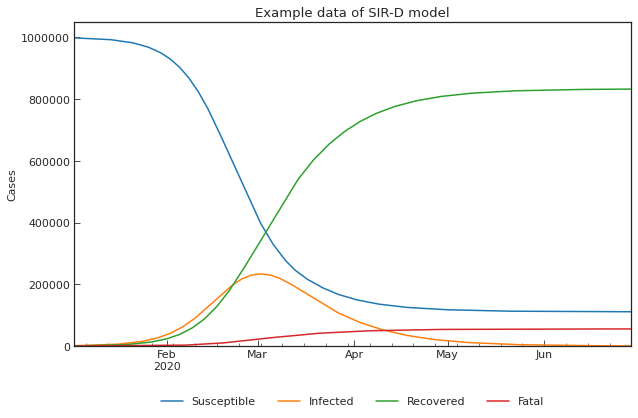

In [41]:
model = cs.SIRD
area = {"country": "Full", "province": model.NAME}
# Add records with SIR model
example_data.add(model, **area)
# Records with model variables
df = example_data.specialized(model, **area)
cs.line_plot(
    df.set_index("Date"),
    title=f"Example data of {model.NAME} model",
    y_integer=True
)

There is an inflection point of y (the number of currentry infected cases per total population). At this point, value of x (the number of susceptible cases per total population) is nearly equal to $\frac{1}{R_0}$.

In [42]:
eg_r0 = model(model.EXAMPLE["population"], **model.EXAMPLE["param_dict"]).calc_r0()
df = example_data.specialized(model, **area)
x_max = df.loc[df["Infected"].idxmax(), "Susceptible"] / cs.SIR.EXAMPLE["population"]
(x_max, 1/eg_r0)

(0.397814, 0.4)

## SIR-F model
In the initial phase of COVID-19 outbreak, many cases were confirmed after they died. To consider this issue, "S + I $\to$ Fatal + I" will be added to the model. When $\alpha_{1}=0$, SIR-F model will be the same as SIR-D model.

### What is SIR-F model?

* $\mathrm{S}$: Susceptible (= Population - Confirmed)
* $\mathrm{S}^\ast$: Confirmed and un-categorized
* $\mathrm{I}$: Confirmed and categorized as Infected
* $\mathrm{R}$: Confirmed and categorized as Recovered
* $\mathrm{F}$: Confirmed and categorzied as Fatal


Measurable variables:  
Confirmed = $I+R+F$  
Recovered = $R$  
Deaths = $F$  

Model:  
\begin{align*}
\mathrm{S} \overset{\beta I}{\longrightarrow} \mathrm{S}^\ast \overset{\alpha_1}{\longrightarrow}\ & \mathrm{F}    \\
\mathrm{S}^\ast \overset{1 - \alpha_1}{\longrightarrow}\ & \mathrm{I} \overset{\gamma}{\longrightarrow} \mathrm{R}    \\
& \mathrm{I} \overset{\alpha_2}{\longrightarrow} \mathrm{F}    \\
\end{align*}

$\alpha_1$: Direct fatality probability of $\mathrm{S}^\ast$ (non-dimentional)   
$\alpha_2$: Mortality rate of Infected cases [1/min]  
$\beta$: Effective contact rate [1/min]  
$\gamma$: Recovery rate [1/min]  

Note: When $\alpha_1 = 0$, SIR-F model is the same as SIR-D model.

Ordinary Differential Equation (ODE):   
\begin{align*}
& \frac{\mathrm{d}S}{\mathrm{d}T}= - N^{-1}\beta S I  \\
& \frac{\mathrm{d}I}{\mathrm{d}T}= N^{-1}(1 - \alpha_1) \beta S I - (\gamma + \alpha_2) I  \\
& \frac{\mathrm{d}R}{\mathrm{d}T}= \gamma I  \\
& \frac{\mathrm{d}F}{\mathrm{d}T}= N^{-1}\alpha_1 \beta S I + \alpha_2 I  \\
\end{align*}

Where $N=S+I+R+F$ is the total population, $T$ is the elapsed time from the start date.

Notes on $\mathrm{S}^\ast$ variable:  
$\mathrm{S}^\ast$ describes the cases who are actually carriers of the disease without anyone (including themselves) knowing about it, who either die and they are confirmed positive after death, while some others are moved to infected after being confirmed.

In JHU-style dataset, we know the number of cases who were confirmed with COVID-19, but we do not know the number of died cases who died without COVID-19.
Essentially $\mathrm{S}^\ast$ serves as an auxiliary compartment in SIR-F model to separate the two death situations and insert a probability factor of {$\alpha$, $1 - \alpha$}.

Notes on the difference of SIR-D and SIR-F model:  
$\alpha_1$ is small at this time because performance of PCR tests was improved, but we can use SIR-F model rather than SIR-D model as an enhanced model even now becase $\alpha_1$ can be 0 in the ODE model.

### Non-dimensional SIR-F model
Set $(S, I, R, F) = N \times (x, y, z, w)$ and $(T, \alpha_1, \alpha_2, \beta, \gamma) = (\tau t, \theta, \tau^{-1} \kappa, \tau^{-1} \rho, \tau^{-1} \sigma)$.  
This results in the ODE  
\begin{align*}
& \frac{\mathrm{d}x}{\mathrm{d}t}= - \rho x y  \\
& \frac{\mathrm{d}y}{\mathrm{d}t}= \rho (1-\theta) x y - (\sigma + \kappa) y  \\
& \frac{\mathrm{d}z}{\mathrm{d}t}= \sigma y  \\
& \frac{\mathrm{d}w}{\mathrm{d}t}= \rho \theta x y + \kappa y  \\
\end{align*}

Where $N$ is the total population and $\tau$ is a coefficient ([min], is an integer to simplify).  

The range of variables and parameters:  
\begin{align*}
& 0 \leq (x, y, z, w, \theta, \kappa, \rho, \sigma) \leq 1  \\
\end{align*}
\begin{align*}
& 1\leq \tau \leq 1440  \\
\end{align*}

Reproduction number can be defined as  
\begin{align*}
R_0 = \rho (1 - \theta) (\sigma + \kappa)^{-1} = \beta (1 - \alpha_1) (\gamma + \alpha_2)^{-1}
\end{align*}

### Example of non-dimensional SIR-F model

In [43]:
# Model name
print(cs.SIRF.NAME)
# Example parameter values
pprint(cs.SIRF.EXAMPLE, compact=True)

SIR-F
{'param_dict': {'kappa': 0.005, 'rho': 0.2, 'sigma': 0.075, 'theta': 0.002},
 'population': 1000000,
 'step_n': 180,
 'y0_dict': {'Fatal': 0,
             'Infected': 1000,
             'Recovered': 0,
             'Susceptible': 999000}}


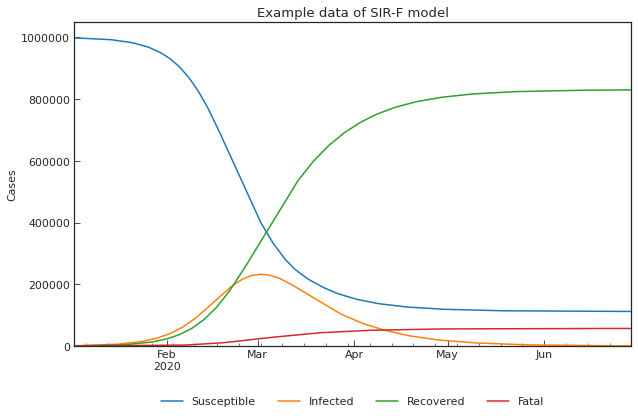

In [44]:
model = cs.SIRF
area = {"country": "Full", "province": model.NAME}
# Add records with SIR model
example_data.add(model, **area)
# Records with model variables
df = example_data.specialized(model, **area)
cs.line_plot(
    df.set_index("Date"),
    title=f"Example data of {model.NAME} model",
    y_integer=True
)

There is an inflection point of y (the number of currentry infected cases per total population). At this point, value of x (the number of susceptible cases per total population) is nearly equal to $\frac{1}{R_0}$.

In [45]:
eg_r0 = model(model.EXAMPLE["population"], **model.EXAMPLE["param_dict"]).calc_r0()
df = example_data.specialized(model, **area)
x_max = df.loc[df["Infected"].idxmax(), "Susceptible"] / cs.SIR.EXAMPLE["population"]
(x_max, 1/eg_r0)

(0.401442, 0.4)

### Hyperparameter optimization
In the previous paragraphs figures, we calculated the number of cases based on hypothesized parameter values. However, we do not know parameter values of the actual data. Here, we will estimate the ($\theta, \kappa, \rho, \sigma$) values of the example data using hyperparameter optimization method by Optuna package. $\tau$ will be fixed as 1440 [min].

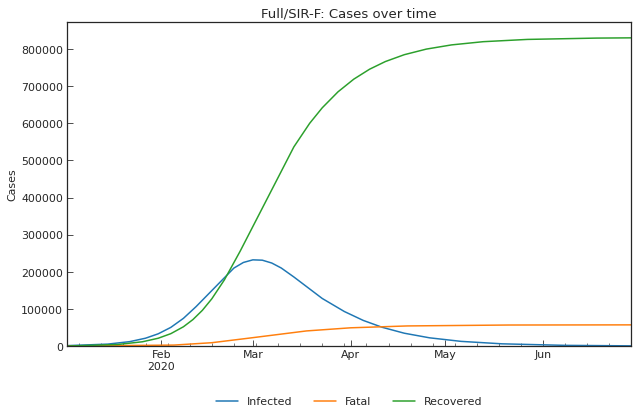

In [46]:
# Show records in JHU-style
sirf_snl = cs.Scenario(example_data, tau=1440, **area)
_ = sirf_snl.records()

In [47]:
# Set phases (phase: explained in "S-R trend analysis section")
# Records at 01Jan2020 will be removed because Recovered = 0
sirf_snl.clear(include_past=True)
sirf_snl.add().summary()

,Type,Start,End,Population
0th,Past,02Jan2020,29Jun2020,1000000


In [48]:
# Parameter estimation
sirf_snl.estimate(cs.SIRF)


<SIR-F model: parameter estimation>
Running optimization with 4 CPUs...
	02Jan2020 - 29Jun2020: finished  321 trials in 0 min 10 sec
Completed optimization. Total: 0 min 10 sec


Trajectorie of parameter values in hyperparameter estimation are shown here.

Estimated parameter values are shown here.

In [49]:
df = sirf_snl.summary()
setting_model = cs.SIRF(population=cs.SIRF.EXAMPLE["population"], **cs.SIRF.EXAMPLE["param_dict"])
setting_dict = {
    "Population": cs.SIRF.EXAMPLE["population"],
    "ODE": cs.SIRF.NAME,
    "Rt": setting_model.calc_r0(),
    "tau": 1440,
    **setting_model.calc_days_dict(1440),
    **cs.SIRF.EXAMPLE["param_dict"]
}
df = df.append(pd.Series(setting_dict, name="setting"))
df.fillna("-")

,Type,Start,End,Population,ODE,Rt,theta,kappa,rho,sigma,tau,alpha1 [-],1/alpha2 [day],1/beta [day],1/gamma [day],RMSLE,Trials,Runtime
0th,Past,02Jan2020,29Jun2020,1000000,SIR-F,2.48,0.000561,0.005189,0.199823,0.075206,1440,0.001,192,5,13,0.008749,321.0,0 min 10 sec
setting,-,-,-,1000000,SIR-F,2.50,0.002000,0.005000,0.200000,0.075000,1440,0.002,200,5,13,-,-,-


Note:  
"Score" is Root Mean Squared Log Error (RMSLE) score.
\begin{align*}
& \sqrt{\cfrac{1}{n}\sum_{i=1}^{n}(log_{10}(A_{i} + 1) - log_{10}(P_{i} + 1))^2}
\end{align*}
Where $A$ is observed (actual) values, $P$ is estimated (predicted) values. Variables are $S$ ($i=1$), $I$ ($i=2$), $R$ ($i=3$) and $F$ ($i=n=4$) for SIR-F model. When RMSLE score is low, hyperparameter estimation is highly accurate.  
Please refer to [What’s the Difference Between RMSE and RMSLE?](https://medium.com/analytics-vidhya/root-mean-square-log-error-rmse-vs-rmlse-935c6cc1802a)

Comparison of observed values and estimated values is shown here.

Note:  
This figures show the accuracy for each parameter. When "v_observed" and "v_estimated" (v=y, z, w) is overlapping, highly accurate.

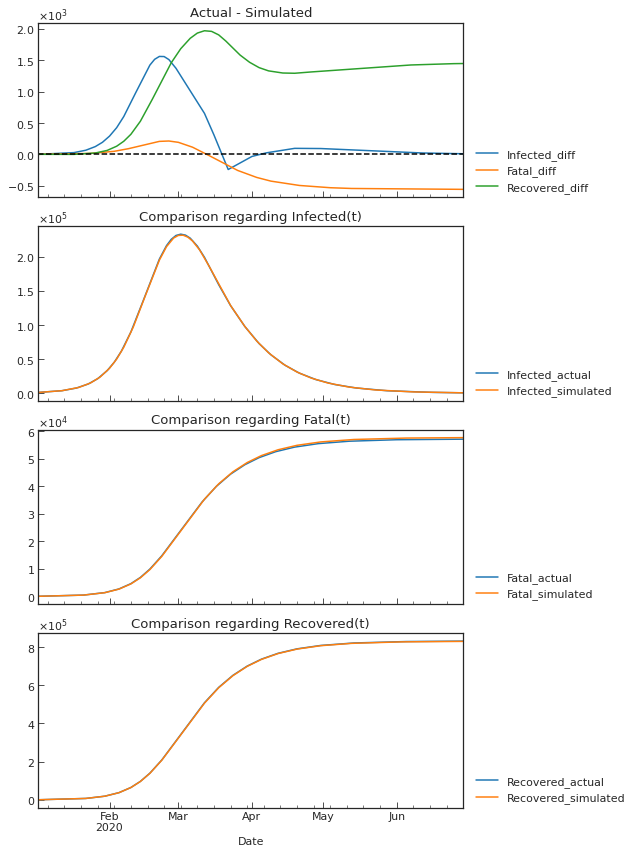

In [50]:
sirf_snl.estimate_accuracy("0th")

# SIR-F with exposed/waiting cases<a id="5"></a>
The number of exposed cases in latent period (E) and wating cases for confirmation (W) are un-measurable variables, but key variables as well as S, I, R, F. If E and W are large, outbreak will occur in the near future. Let's replace S $\overset{\beta I}{\longrightarrow}$ S$^\ast$ with S $\overset{\beta_1 (W+I)}{\longrightarrow}$ E $\overset{\beta_2}{\longrightarrow}$ W $\overset{\beta_3}{\longrightarrow}$ S$^\ast$ because W also has infectivity.

Note:  
W and some rules were added to explain COVID-19 dataset, but this is like-SEIR model.  
To study general SEIR-model, please refer to PDF material in [Introduction to SEIR model Models](http://indico.ictp.it/event/7960/session/3/contribution/19/material/slides/).

## What is SEWIR-F model?

* $\mathrm{S}$: Susceptible
* $\mathrm{E}$: <u>Exposed and in latent period (without infectivity)</u>
* $\mathrm{W}$: <u>Waiting for confirmaion fiagnosis (with infectivity)</u>
* $\mathrm{S}^\ast$: Confirmed and un-categorized
* $\mathrm{I}$: Confirmed and categorized as Infected
* $\mathrm{R}$: Confirmed and categorized as Recovered
* $\mathrm{F}$: Confirmed and categorzied as Fatal

Measurable variables:  
Total population - Confirmed = $S+E+W+S^\ast$  
Confirmed = $I+R+F$  
Recovered = $R$  
Deaths = $F$  

Model:  
\begin{align*}
\mathrm{S} \overset{\beta_1 (W+I)}{\longrightarrow} \mathrm{E} \overset{\beta_2}{\longrightarrow} \mathrm{W} \overset{\beta_3}{\longrightarrow} \mathrm{S}^\ast \overset{\alpha_1}{\longrightarrow}\ & \mathrm{F}    \\
\mathrm{S}^\ast \overset{1 - \alpha_1}{\longrightarrow}\ & \mathrm{I} \overset{\gamma}{\longrightarrow} \mathrm{R}    \\
& \mathrm{I} \overset{\alpha_2}{\longrightarrow} \mathrm{F}    \\
\end{align*}

* $\alpha_1$: Mortality rate of $\mathrm{S}^\ast$ cases $\mathrm{[1/min]}$
* $\alpha_2$: Mortality rate of Infected cases $\mathrm{[1/min]}$
* $\beta_1$: <u>Exposure rate (the nymber of encounter with the virus in a minute)</u> $\mathrm{[1/min]}$
* $\beta_2$: <u>Inverse of latent period</u> $\mathrm{[1/min]}$
* $\beta_3$: <u>Inverse of waiting time for confirmation</u> $\mathrm{[1/min]}$
* $\gamma$: Recovery rate $\mathrm{[1/min]}$

Ordinary Differential Equation (ODE):   
\begin{align*}
& \frac{\mathrm{d}S}{\mathrm{d}T}= - N^{-1}\beta_1 S (W + I)  \\
& \frac{\mathrm{d}E}{\mathrm{d}T}= N^{-1}\beta_1 S (W + I) - \beta_2 E  \\
& \frac{\mathrm{d}W}{\mathrm{d}T}= \beta_2 E - \beta_3 W  \\
& \frac{\mathrm{d}I}{\mathrm{d}T}= (1 - \alpha_1)\beta_3 W - (\gamma + \alpha_2) I  \\
& \frac{\mathrm{d}R}{\mathrm{d}T}= \gamma I  \\
& \frac{\mathrm{d}F}{\mathrm{d}T}= \alpha_1 \beta_3 W + \alpha_2 I  \\
\end{align*}

Where $N=S+E+W+I+R+F$ is the total population, $T$ is the elapsed time from the start date.

## Non-dimensional SEWIR-F model
Set $(S, E, W, I, R, F) = N \times (x_1, x_2, x_3, y, z, w)$, $(T, \alpha_1) = (\tau t, \theta)$ and $(\alpha_2, \beta_i, \gamma) = \tau^{-1} \times (\kappa, \rho_i, \sigma)$.  
This results in the ODE  
\begin{align*}
& \frac{\mathrm{d}x_1}{\mathrm{d}t}= - \rho_1 x_1 (x_3 + y)  \\
& \frac{\mathrm{d}x_2}{\mathrm{d}t}= \rho_1 x_1 (x_3 + y) - \rho_2 x_2  \\
& \frac{\mathrm{d}x_3}{\mathrm{d}t}= \rho_2 x_2 - \rho_3 x_3  \\
& \frac{\mathrm{d}y}{\mathrm{d}t}= (1-\theta) \rho_3 x_3 - (\sigma + \kappa) y  \\
& \frac{\mathrm{d}z}{\mathrm{d}t}= \sigma y  \\
& \frac{\mathrm{d}w}{\mathrm{d}t}= \theta \rho_3 x_3 + \kappa y  \\
\end{align*}

Where $N$ is the total population and $\tau$ is a coefficient ([min], is an integer to simplify).  

The range of variables and parameters:  
\begin{align*}
0 < (x_i, y, z, w, \theta, \kappa, \rho_i, \sigma) < 1\ \mathrm{for}\ i = 1, 2, 3
\end{align*}
\begin{align*}
1 \leq \tau \leq 1440
\end{align*}

Reproduction number can be defined as  
\begin{align*}
R_0 = \rho_1 /\rho_2 * \rho_3 (1-\theta) (\sigma + \kappa)^{-1}
\end{align*}

## Calculate $\rho_2$ and $\rho_3$
To estimate $\rho_2 = \tau \beta_2$ and $\rho_3 = \tau \beta_3$ of COVID-19, we first calculate median value of latent period $\overline{L_{E}}$ and waiting time for confirmation $\overline{L_{W}}$ using linelist. We assume that patients start to have infectivity from onset dates. This means latent period is equal to incubation period.

$\beta_2$: Inverse of latent period [1/min]  
$\beta_3$: Inverse of waiting time for confirmation [1/min]

In [51]:
latent_period = 6 * 24 * 60
waiting_time = 7 * 24 * 60
latent_waiting_day = latent_period + waiting_time

In [52]:
df = cs.SIRF.EXAMPLE["param_dict"]
tau = 1440
eg_rho2, eg_rho3 = tau / latent_period, tau / waiting_time
(eg_rho2, eg_rho3)

(0.16666666666666666, 0.14285714285714285)

### Example of non-dimensional SEWIR-F model
For example, set $\theta=0.002, \kappa=0.005, \rho_1=0.2, \sigma=0.08$ and initial values $(x_{1(0)}, x_{2(0)}, x_{3(0)}, y_{(0)}, z_{(0)}, w_{(0)}) = (0.994, 0.003, 0.002, 0.001, 0, 0)$.

In [53]:
param_dict = cs.SEWIRF.EXAMPLE["param_dict"]
param_dict.update({"rho2":eg_rho2, "eho3": eg_rho3})
pprint(param_dict, compact=True)

{'eho3': 0.14285714285714285,
 'kappa': 0.005,
 'rho1': 0.2,
 'rho2': 0.16666666666666666,
 'rho3': 0.167,
 'sigma': 0.075,
 'theta': 0.002}


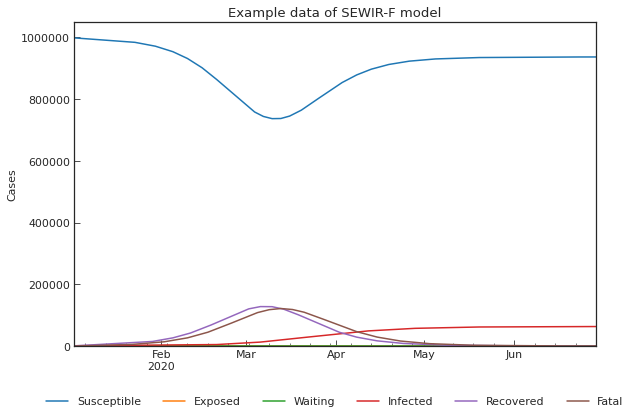

In [54]:
model = cs.SEWIRF
area = {"country": "Full", "province": model.NAME}
# Add records with SIR model
example_data.add(model, param_dict=param_dict, **area)
# Records with model variables
df = example_data.specialized(model, **area)
cs.line_plot(
    df.set_index("Date"),
    title=f"Example data of {model.NAME} model",
    y_integer=True
)

# Factors of model parameters<a id="6"></a>
To figure out what to do for minimizing the damage, we will perform scenario analysis in the next part. In this section, we will define the control factors of the SIR-F parameters.
Here, we will use the following scenarios. For explanation, $\tau=1440$, the start date is 01Jan2020, population is 1,000,000 and country name is “Theoretical”. **This is not based on actual data.**

Comment:  
For accurate SEWIR-F prediction, we need to calculate $\rho_1$ and $\rho_2$ with linelist (case reports) of each country. However, it is difficult to get enough data for all countries and we will use SIR-F model as the main model in scenario analysis part.

In [55]:
# Preset of SIR-F parameters
preset_dict = cs.SIRF.EXAMPLE["param_dict"]
preset_dict

{'theta': 0.002, 'kappa': 0.005, 'rho': 0.2, 'sigma': 0.075}

In [56]:
area = {"country": "Theoretical"}
# Create dataset from 01Jan2020 to 31Jan2020
example_data.add(cs.SIRF, step_n=30, **area)

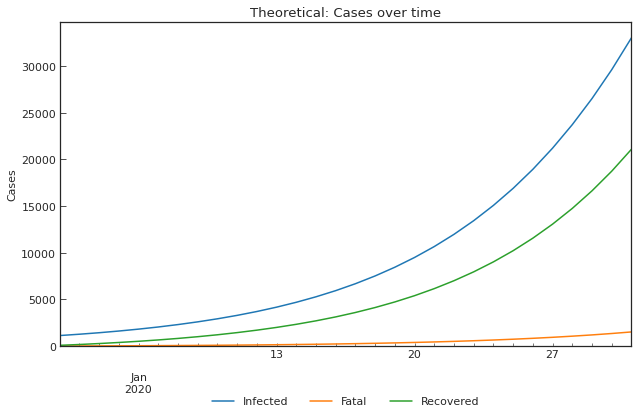

,Date,Infected,Fatal,Recovered
0,2020-01-02,1127,6,80
1,2020-01-03,1270,12,169
2,2020-01-04,1430,19,271
3,2020-01-05,1612,28,385
4,2020-01-06,1816,37,513


,Date,Infected,Fatal,Recovered
25,2020-01-27,21210,940,13068
26,2020-01-28,23730,1061,14753
27,2020-01-29,26524,1196,16637
28,2020-01-30,29616,1347,18741
29,2020-01-31,33030,1515,21088


In [57]:
# Show records with Scenario class
snl = cs.Scenario(example_data, tau=1440, **area)
record_df = snl.records()
display(record_df.head())
display(record_df.tail())

## Control factors of effective contact rate $\beta_1$
Please reconsider S $\overset{\beta_1 (W+I)}{\longrightarrow}$ E formula. Susceptible persons may contact with waiting/confirmed patients, and susceptible persons will be infected with COVID-19. The formura can be replaced with  
\begin{alignat}{1}
{\mathrm{S}}_{\mathrm{q}} & \overset{g_{s}}{\Longleftrightarrow} {\mathrm{S}}_{\mathrm{g}} \overset{f_1}
 {\longrightarrow} \ & \mathrm{E}^\ast \overset{e^{-h_2}}{\longrightarrow} \mathrm{E}   \\
& & \mathrm{E}^\ast \overset{1-e^{-h_2}}{\longrightarrow} \mathrm{R}^\ast  \\
\mathrm{W}_\mathrm{q} & \overset{g_w}{\Longleftrightarrow} \mathrm{W}_{\mathrm{g}}  \\
\mathrm{I}_\mathrm{q} & \overset{g_i}{\Longleftrightarrow} \mathrm{I}_{\mathrm{g}}  \\
\mathrm{I}_\mathrm{q} & \overset{q}{\longrightarrow} \mathrm{I}_{\hat{\mathrm{q}}}  \\
\end{alignat}

$\Longleftrightarrow$ (as substitute for $\longrightarrow$ with $\longleftarrow$) means that right side can be return to the left side.  
S$_\mathrm{q}$: Susceptible persons with self-quaranting <!--Susceptible in the strict sense-->  
S$_\mathrm{g}$: Susceptible persons with family members or friends etc.  
W$_\mathrm{q}$: Waiting patients with self-quaranting  
W$_\mathrm{g}$: Waiting patients with family members or friends etc.  
I$_\mathrm{q}$: Confimered and un-recovered patients with self-quaranting  
I$_\mathrm{g}$: Confimered and un-recovered patients with family members or friends etc.  
I$_\hat{\mathrm{q}}$: Confimered and un-recovered patients who was hospitalized  
E$^\ast$: Just after being exposed to the virus  
R$^\ast$: Being exposed to the virus, fighted with the virus, recovered and immuned without confirmation  

$f_1 = v(W_{\mathrm{g}} + I_{\mathrm{g}})(1-m)^2(1-w_e)^{w_n}e^{-h_1}c$ [-] 

Control factors:  
$g_s$: The number of days in <u>a week</u> susceptible persons go out [day]  
$g_w$: The number of days in <u>a week</u> waiting but un-quarantined persons go out [day]  
$g_i$: The number of days in <u>a week</u> currently infected (confirmed) but un-quarantined persons go out [day]  
$q$: Quarantine rate of currently infected (confirmed) patients [-]  
$v$: Probability of virus existance in a droplet [-]  
$m$: Rate of persons wearing masks effectively (depends logistically on supply of masks) [-]  
$w_e$: Virus reduction effect of washing hands [-]  
$w_n$: The number of times people washes their hands before touching their own faces after go out [-]  
$h_1$: Health condition (active rate of cellular immunity factors) of susceptible and contacted persons [-]  
$h_2$: Health condition (active rate of humoral immunity factors) of susceptible and contacted persons [-]  
$c$: The number of contacts between susceptible persons and patients while on the go in a minute (depends on population density) [1/min]  
$\delta$:The product of unknown real factors [-]  

The parameter in the math model:  
$\beta_1 = \cfrac{1}{49}[g_s \{g_w + g_i (1-q) \} v (1-m)^2 (1-w_e)^{w_n} e^{-(h_{1}+h_{2})} c \delta]$ [1/min]

In [58]:
# Value of beta before actions are taken
rho_before = cs.SIRF.EXAMPLE["param_dict"]["rho"]
rho_before

0.2

**As a example, we will predict the impact of lockdown. The number of days in a week susceptible persons go out, $g_s$, will be minimized.**

### $g_s$ value before actions are taken
$g_s$: The number of days in <u>a week</u>, susceptible persons go out [day]  

We can calculate weighted average of days with age composion of population. Population pyramid in Italy will be used as an example.

In [59]:
eg_out_df = go_out("Italy")
eg_out_df

,Age_first,Age_last,Period_of_life,School,Office,Others,Age,Population,Portion
0,0,2,nursery,3,0,0,2,1373871,0.025722
1,3,5,nursery school,4,0,1,5,1441955,0.026997
2,6,10,elementary school,5,0,1,10,2667055,0.049933
3,11,13,middle school,5,0,1,13,1688673,0.031616
4,14,18,high school,6,0,1,18,2829215,0.052969
5,19,25,university/work,3,3,1,25,4087599,0.076529
6,26,35,work,0,6,1,35,6521421,0.122096
7,36,45,work,0,5,1,45,7940871,0.148671
8,46,55,work,0,5,1,55,9560703,0.178998
9,56,65,work,0,5,1,65,8261046,0.154666


$g_s$ value is

In [60]:
gs_before = (eg_out_df[["School", "Office", "Others"]].sum(axis=1) * eg_out_df["Portion"]).sum()
gs_before

5.794427227320437

### $g_s$ value AFTER actions are taken
We will assume the following situation (lockdown) here.
* All schools are closed
* offices are closed and 50% of people works remotely.
* People will go out one day for other reasons instead of going to school/office.

In [61]:
df = eg_out_df.copy()
df.loc[df["School"] + df["Office"] > 0, "Others"] += 1
df["School"] = 0
df["Office"] *= 0.5
eg_out_df_after = df.copy()
eg_out_df_after

,Age_first,Age_last,Period_of_life,School,Office,Others,Age,Population,Portion
0,0,2,nursery,0,0.0,1,2,1373871,0.025722
1,3,5,nursery school,0,0.0,2,5,1441955,0.026997
2,6,10,elementary school,0,0.0,2,10,2667055,0.049933
3,11,13,middle school,0,0.0,2,13,1688673,0.031616
4,14,18,high school,0,0.0,2,18,2829215,0.052969
5,19,25,university/work,0,1.5,2,25,4087599,0.076529
6,26,35,work,0,3.0,2,35,6521421,0.122096
7,36,45,work,0,2.5,2,45,7940871,0.148671
8,46,55,work,0,2.5,2,55,9560703,0.178998
9,56,65,work,0,2.5,2,65,8261046,0.154666


In [62]:
df = eg_out_df_after.copy()
gs_after = (df[["School", "Office", "Others"]].sum(axis=1) * df["Portion"]).sum()
gs_after

3.8354021528726467

## Impact of actions on $\beta$
In SIR-F model $g_s$ is a control factor of $\beta$.  
Actions taken at 15th day:  
All schools and offices will be closed.  

In [63]:
rho_after = rho_before * (gs_after / gs_before)
rho_after / rho_before

0.6619122136505426

## Predict the number of cases: with the effect of actions from 32th day
There is a delay between the time point of starting actions and that of appearing the effect. Because $I$ is the main variable, the length of delay can be estimated as sum of latent period and waiting time for confirmation. This value [day] was calculated in "SIR-F with exposed/waiting cases" section.

##预测病例数量：从第32天起采取措施
在开始行动的时间点和出现效果的时间点之间存在延迟。由于$I$是主要变量，因此延迟的长度可以估计为等待确认的潜伏期和等待时间的总和。该值[天]在“SIR-F暴露/等待病例”部分计算。

In [64]:
# Set 0th phase from 02Jan2020 to 31Jan2020 with preset parameter values
snl.clear(include_past=True)
snl.add(end_date="31Jan2020", model=cs.SIRF, **preset_dict)
snl.summary()
# Add main scenario: the same parameter to 31Dec2020
snl.add(end_date="31Dec2020", name="Main")
# Add lockdown scenario
snl.clear(include_past=False, name="Lockdown")
snl.add(end_date="31Dec2020", name="Lockdown", rho=rho_after).summary()

Type      Start        End  Population    ODE    Rt  theta  \
Scenario Phase                                                                 
Main     0th      Past  02Jan2020  31Jan2020     1000000  SIR-F  2.50  0.002   
         1st    Future  01Feb2020  31Dec2020     1000000  SIR-F  2.50  0.002   
Lockdown 0th      Past  02Jan2020  31Jan2020     1000000  SIR-F  2.50  0.002   
         1st    Future  01Feb2020  31Dec2020     1000000  SIR-F  1.65  0.002   

                kappa       rho  sigma   tau  alpha1 [-]  1/alpha2 [day]  \
Scenario Phase                                                             
Main     0th    0.005  0.200000  0.075  1440       0.002           200.0   
         1st    0.005  0.200000  0.075  1440       0.002           200.0   
Lockdown 0th    0.005  0.200000  0.075  1440       0.002           200.0   
         1st    0.005  0.132382  0.075  1440       0.002           200.0   

                1/beta [day]  1/gamma [day]  
Scenario Phase                               
Main     0th             5.0           13.0  
         1st             5.0           13.0  
Lockdown 0th             5.0           13.0  
         1st             7.0           13.0

No actions:

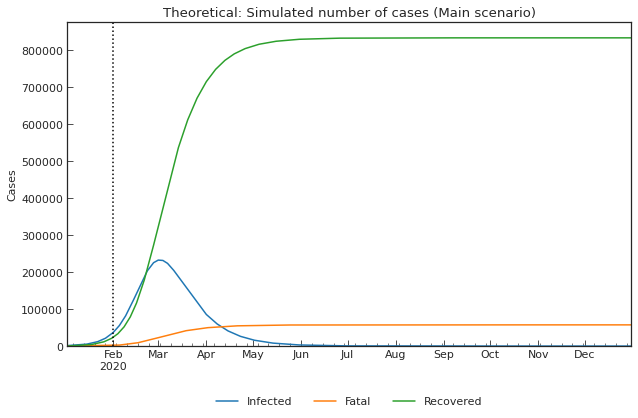

In [65]:
_ = snl.simulate(name="Main")

With lockdown:

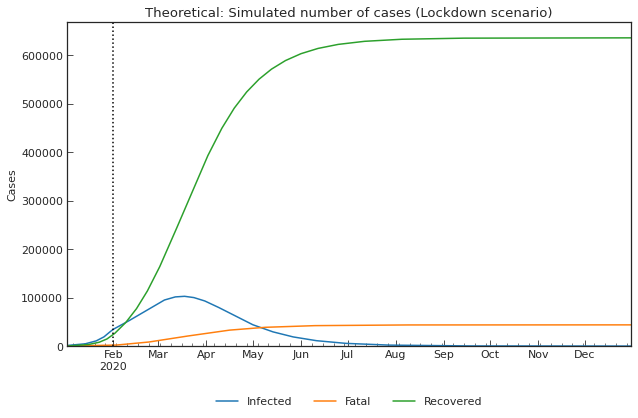

In [66]:
_ = snl.simulate(name="Lockdown")

In [67]:
snl.describe()

,max(Infected),argmax(Infected),Confirmed on 31Dec2020,Infected on 31Dec2020,Fatal on 31Dec2020,1st_Rt
Main,232800,02Mar2020,890043,0,57295,2.50
Lockdown,102662,17Mar2020,679116,6,43716,1.65


The actions result in:  
* reduction of max value of Infected,
* delay of peak point (argmax) of Infected, and
* extention of period with COVID-19.

## Control factors of recovery rate $\gamma$ and mortality rate $\alpha_2$
Here, let's reconsider I $\overset{\gamma}{\longrightarrow}$ R and I $\overset{\alpha_2}{\longrightarrow}$ F.  
Because balance of immunity (+effect of treatments) and virulence determines whether patients can recover or not, the formulas can be replaced with  

\begin{align*}
& \mathrm{I} \overset{\bar{h}}{\longrightarrow} \mathrm{I}^\star \overset{\bar{s}}{\longrightarrow} \mathrm{F}^\star \overset{L^{-1}}{\longrightarrow} \mathrm{F}    \\
& \mathrm{I} \overset{f_2}{\longrightarrow} \mathrm{R}^\star \overset{l^{-1}}{\longrightarrow} \mathrm{R}    \\
\end{align*}

I$^\star$: Confirmed cases whose immune systems did not overcome virus multiplication, and <u>without</u> severe events  
F$^\star$: Confirmed cases whose immune systems did not overcome virus multiplication, and <u>with</u> severe events  
R$^\star$: Confirmed cases whose immune systems overcame virus multiplication or comfirmed cases whose severe events can be stopped

$f_2 = 1 - \bar{h}\ \bar{s}$  

$\bar{h}$: Rate of I whose immune systems does NOT overcame virus multiplication [-]  
$\bar{s}$: Rate of I$^\star$ who have severe events, including respiratory failure  [-]  
$L_i$: Inverse of F$^\star$'s mortality rate for people $i$ years old [min]  
$l_i$: Inverse of R$^\star$'s mortality rate for people $i$ years old [min]  
$P_i$: The number of people $i$ years old [-]  
$N$: Total population  

\begin{align*}
& \alpha_2 = \cfrac{\bar{h}\ \bar{s}}{N} \sum_{n=0}^{\infty}\cfrac{P_{i}}{L_i} \\
& \gamma = \cfrac{1 - \bar{h}\ \bar{s}}{N} \sum_{n=0}^{\infty}\cfrac{P_{i}}{l_i} \\
\end{align*}

## $\bar{h}$ and $\bar{s}$ value before actions are taken
We assume that $\bar{h}=0.5$ and $\bar{s}=0.5$.  
**(Using population distribution data and case reports, $\bar{h}\ \bar{s}$ and $1 - \bar{h}\ \bar{s}$ can be calculated.)**

In [68]:
sigma_before = preset_dict["sigma"]
kappa_before = preset_dict["kappa"]
(sigma_before, kappa_before)

(0.075, 0.005)

In [69]:
h_bar_before, s_bar_before = 0.5, 0.5

## $\bar{h}$ and $\bar{s}$ value AFTER actions are taken
Assumtions of new medicines:  
"Protease inhibitor" inhibits virus multiplication. This will reduce $\bar{h}$. We assume that $\bar{h}$ will be 10% of $\bar{h}_{before}$.

In [70]:
h_bar_after = h_bar_before * 0.1
s_bar_after = s_bar_before
(h_bar_after, s_bar_after)

(0.05, 0.5)

## Impact on $\gamma$ and $\alpha_2$
Actions to take:  
New Protein inhibitor medicine was introduced.

In [71]:
sigma_after = sigma_before * (1 - h_bar_after * s_bar_after) / (1 - h_bar_before * s_bar_before)
sigma_after

0.09749999999999999

In [72]:
kappa_after = kappa_before * (h_bar_after * s_bar_after) / (h_bar_before * s_bar_before)
kappa_after

0.0005

## Predict the number of case: with effect of new medicines from 32th day

In [73]:
# Add medicine scenario
snl.clear(name="Medicine")
snl.add(end_date="31Dec2020", name="Medicine", kappa=kappa_after, sigma=sigma_after)
snl.summary()

Type      Start        End  Population    ODE    Rt  theta  \
Scenario Phase                                                                 
Main     0th      Past  02Jan2020  31Jan2020     1000000  SIR-F  2.50  0.002   
         1st    Future  01Feb2020  31Dec2020     1000000  SIR-F  2.50  0.002   
Lockdown 0th      Past  02Jan2020  31Jan2020     1000000  SIR-F  2.50  0.002   
         1st    Future  01Feb2020  31Dec2020     1000000  SIR-F  1.65  0.002   
Medicine 0th      Past  02Jan2020  31Jan2020     1000000  SIR-F  2.50  0.002   
         1st    Future  01Feb2020  31Dec2020     1000000  SIR-F  2.04  0.002   

                 kappa       rho   sigma   tau  alpha1 [-]  1/alpha2 [day]  \
Scenario Phase                                                               
Main     0th    0.0050  0.200000  0.0750  1440       0.002           200.0   
         1st    0.0050  0.200000  0.0750  1440       0.002           200.0   
Lockdown 0th    0.0050  0.200000  0.0750  1440       0.002           200.0   
         1st    0.0050  0.132382  0.0750  1440       0.002           200.0   
Medicine 0th    0.0050  0.200000  0.0750  1440       0.002           200.0   
         1st    0.0005  0.200000  0.0975  1440       0.002          2000.0   

                1/beta [day]  1/gamma [day]  
Scenario Phase                               
Main     0th             5.0           13.0  
         1st             5.0           13.0  
Lockdown 0th             5.0           13.0  
         1st             7.0           13.0  
Medicine 0th             5.0           13.0  
         1st             5.0           10.0

No actions:

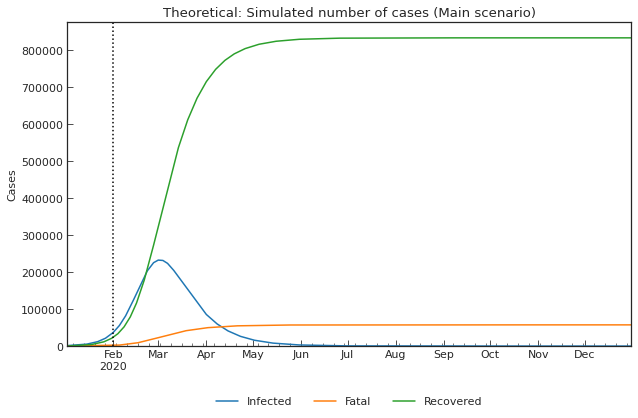

In [74]:
_ = snl.simulate(name="Main")

With new medicines:

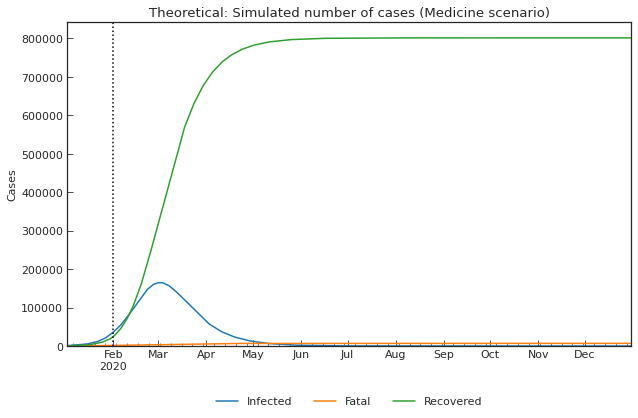

In [75]:
_ = snl.simulate(name="Medicine")

In [76]:
snl.describe()

,max(Infected),argmax(Infected),Confirmed on 31Dec2020,Infected on 31Dec2020,Fatal on 31Dec2020,1st_Rt
Main,232800,02Mar2020,890043,0,57295,2.50
Lockdown,102662,17Mar2020,679116,6,43716,1.65
Medicine,165235,02Mar2020,808440,0,7023,2.04


New medicines result in:  
* reduction of max value of Infected,
* reduction of Fatal, and
* shortened period with COVID-19.

## SIR-F model with vaccination
In the previous version, we defined SIR-FV model as follows.

\begin{align*}
& \frac{\mathrm{d}x}{\mathrm{d}t}= - \rho x y - \omega  \\
& \frac{\mathrm{d}y}{\mathrm{d}t}= \rho (1-\theta) x y - (\sigma + \kappa) y  \\
& \frac{\mathrm{d}z}{\mathrm{d}t}= \sigma y  \\
& \frac{\mathrm{d}w}{\mathrm{d}t}= \rho \theta x y + \kappa y  \\
\end{align*}

Where $\omega_{(x>0)}=\frac{\mathrm{10,000}}{N}$ and $N$ is the total population when 10,000 persons will be vacctinated in one day until there are no susceptible people.

However, <u>**SIR-FV model was removed because vaccinated persons may move to the other compartments. Please use SIR-F model and adjust parameter values of SIR-F model, considering the impact of vaccinations on infectivity, effectivity and safety.**</u>

As an example, we assume that, in vaccinated world, <u>**rho is 80% of the main scenario**</u> (decreased because of infectivity was reduced), <u>**sigma is 120%**</u> (increased because severity rate was reduced) and <u>**kappa is 60%**</u> (increased because severity rate was reduced). Note that this is not based on actual data.

In [77]:
# Add vaccine scenario
snl.clear("Vaccine")
rho_vac = snl.get("rho", phase="0th") * 0.8
sigma_vac = snl.get("sigma", phase="0th") * 1.2
kappa_vac = snl.get("kappa", phase="0th") * 0.6
snl.add(end_date="31Dec2020", name="Vaccine",  rho=rho_vac, kappa=kappa_vac, sigma=sigma_vac)
snl.summary()

Type      Start        End  Population    ODE    Rt  theta  \
Scenario Phase                                                                 
Main     0th      Past  02Jan2020  31Jan2020     1000000  SIR-F  2.50  0.002   
         1st    Future  01Feb2020  31Dec2020     1000000  SIR-F  2.50  0.002   
Lockdown 0th      Past  02Jan2020  31Jan2020     1000000  SIR-F  2.50  0.002   
         1st    Future  01Feb2020  31Dec2020     1000000  SIR-F  1.65  0.002   
Medicine 0th      Past  02Jan2020  31Jan2020     1000000  SIR-F  2.50  0.002   
         1st    Future  01Feb2020  31Dec2020     1000000  SIR-F  2.04  0.002   
Vaccine  0th      Past  02Jan2020  31Jan2020     1000000  SIR-F  2.50  0.002   
         1st    Future  01Feb2020  31Dec2020     1000000  SIR-F  1.72  0.002   

                 kappa       rho   sigma   tau  alpha1 [-]  1/alpha2 [day]  \
Scenario Phase                                                               
Main     0th    0.0050  0.200000  0.0750  1440       0.002           200.0   
         1st    0.0050  0.200000  0.0750  1440       0.002           200.0   
Lockdown 0th    0.0050  0.200000  0.0750  1440       0.002           200.0   
         1st    0.0050  0.132382  0.0750  1440       0.002           200.0   
Medicine 0th    0.0050  0.200000  0.0750  1440       0.002           200.0   
         1st    0.0005  0.200000  0.0975  1440       0.002          2000.0   
Vaccine  0th    0.0050  0.200000  0.0750  1440       0.002           200.0   
         1st    0.0030  0.160000  0.0900  1440       0.002           333.0   

                1/beta [day]  1/gamma [day]  
Scenario Phase                               
Main     0th             5.0           13.0  
         1st             5.0           13.0  
Lockdown 0th             5.0           13.0  
         1st             7.0           13.0  
Medicine 0th             5.0           13.0  
         1st             5.0           10.0  
Vaccine  0th             5.0           13.0  
         1st             6.0           11.0

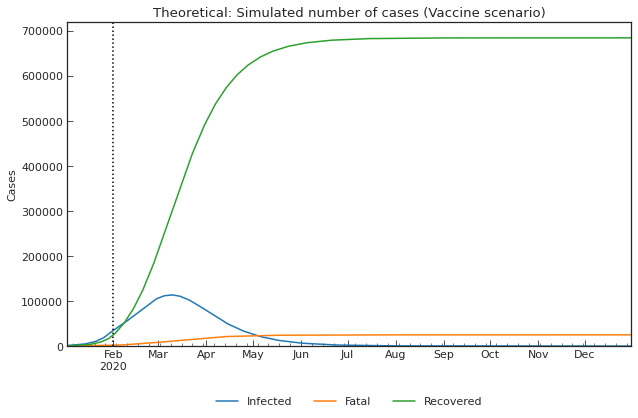

In [78]:
_ = snl.simulate(name="Vaccine")

In [79]:
snl.describe()

,max(Infected),argmax(Infected),Confirmed on 31Dec2020,Infected on 31Dec2020,Fatal on 31Dec2020,1st_Rt
Main,232800,02Mar2020,890043,0,57295,2.50
Lockdown,102662,17Mar2020,679116,6,43716,1.65
Medicine,165235,02Mar2020,808440,0,7023,2.04
Vaccine,113534,09Mar2020,708848,0,24917,1.72


Vaccines result in:  
* reduction of max value of Infected,
* reduction of Fatal, and
* shortened period with COVID-19.

### Comparison of scenarios for each variables
We can compare the number of cases in the scenarios, specifying variables as follows.

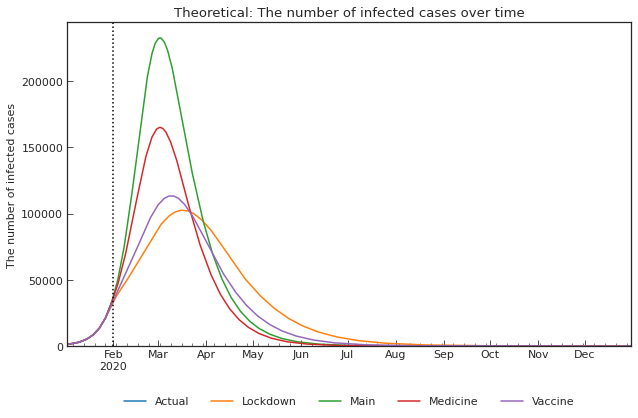

In [80]:
_ = snl.history(target="Infected")

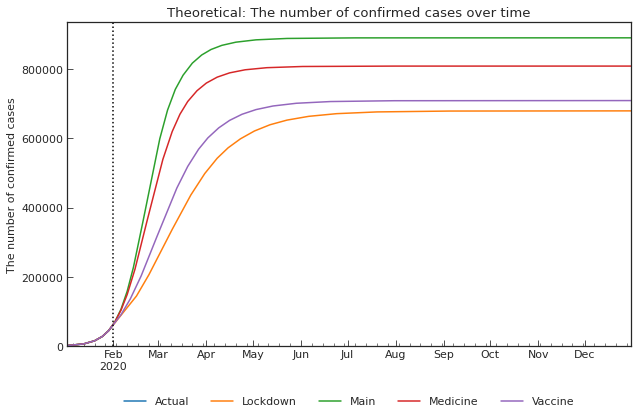

In [81]:
_ = snl.history(target="Confirmed")

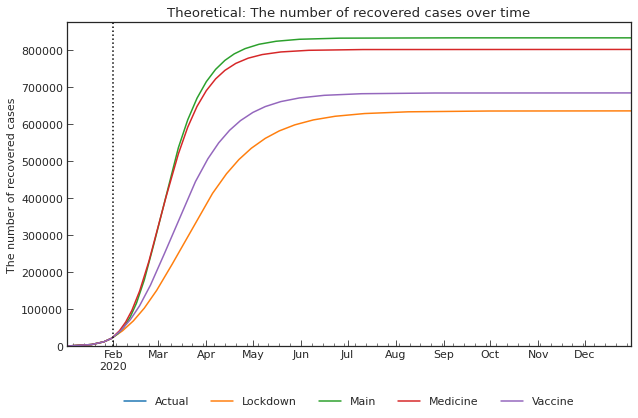

In [82]:
_ = snl.history(target="Recovered")

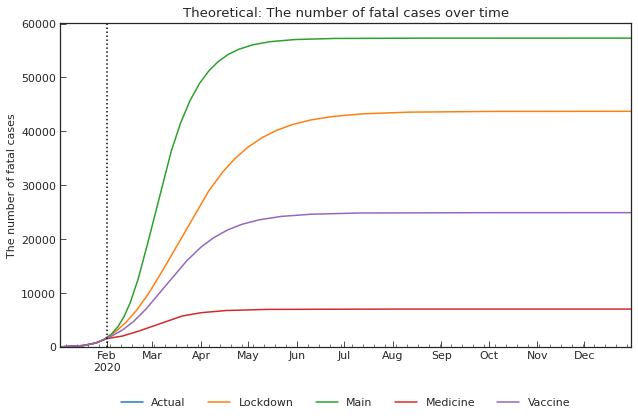

In [83]:
_ = snl.history(target="Fatal")

# S-R trend analysis<a id="10"></a>
In the previous section, we found that parameter values can be changed by actions. To predict the future, we need to recognize the parameter change from the actual records. Here, trend analysis method will be introduced.

## Example datasets
With the same initial values $(x_{(0)}, y_{(0)}, z_{(0)}, w_{(0)})=(0.999, 0.001, 0, 0)$, we will create five SIR-F example datasets.
* Example 1: $(\theta, \kappa, \rho, \sigma) = (0.0002, 0.005, 0.20, 0.075)$
* Example 2: $(\theta, \kappa, \rho, \sigma) = (0.0002, 0.005, \underline{0.40}, 0.075)$, spread quickly
* Example 3: $(\theta, \kappa, \rho, \sigma) = (0.0002, 0.005, \underline{0.15}, 0.075)$, spread slowly
* Example 4: $(\theta, \kappa, \rho, \sigma) = (0.0002, \underline{0.003}, 0.20, \underline{0.150})$, improved heakthcare system
* Example 5: $(\theta, \kappa, \rho, \sigma) = (\underline{0.0000}, 0.005, 0.20, 0.075)$, as the same as SIR-D model

Values are dimensionalized with total population $N=1,000,000$ in the example datasets.

In [84]:
import warnings
warnings.simplefilter("ignore")
df = pd.DataFrame()
eg_step_n = 200
eg_tau= 1440
eg_population = cs.SIR.EXAMPLE["population"]
eg_param_dict = {
    "1": {"theta": 0.0002, "kappa": 0.005, "rho": 0.20, "sigma": 0.075},
    "2": {"theta": 0.0002, "kappa": 0.005, "rho": 0.40, "sigma": 0.075},
    "3": {"theta": 0.0002, "kappa": 0.005, "rho": 0.15, "sigma": 0.075},
    "4": {"theta": 0.0002, "kappa": 0.003, "rho": 0.20, "sigma": 0.150},
    "5": {"theta": 0.0000, "kappa": 0.005, "rho": 0.20, "sigma": 0.075},
}

for (num, _dict) in eg_param_dict.items():
    simulator = cs.ODESimulator(country=f"Example {num}")
    simulator.add(
        model=cs.SIRF,
        step_n=eg_step_n,
        population=eg_population,
        param_dict=_dict,
        y0_dict={"Susceptible": 999_000, "Infected": 1000, "Recovered": 0, "Fatal": 0}
    )
    simulator.run()
    _df = simulator.dim(tau=eg_tau, start_date="22Jan2020")
    df = pd.concat([df, _df], axis=0, ignore_index=True)

df["Confirmed"] = df[["Infected", "Recovered", "Fatal"]].sum(axis=1)
eg_ncov_df = df.copy()
eg_ncov_df.tail()

,Date,Country,Province,Susceptible,Infected,Recovered,Fatal,Confirmed
1000,2020-08-05,Example 5,-,111067,224,833165,55544,888933
1001,2020-08-06,Example 5,-,111062,211,833181,55545,888937
1002,2020-08-07,Example 5,-,111057,199,833197,55546,888942
1003,2020-08-08,Example 5,-,111053,188,833211,55547,888946
1004,2020-08-09,Example 5,-,111049,178,833225,55548,888951


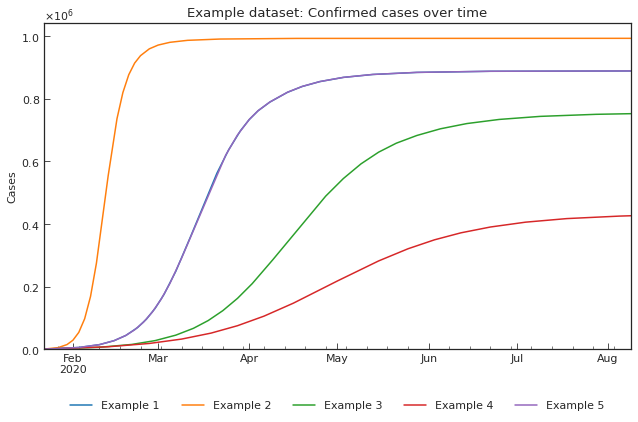

In [85]:
cs.line_plot(
    eg_ncov_df.pivot_table(index="Date", columns="Country", values="Confirmed"),
    "Example dataset: Confirmed cases over time"
)

Values of Example 1 $(\kappa=0.002)$ are nealy equal to that of Example 5 $(\kappa=0.000)$ as shown in the next figure.

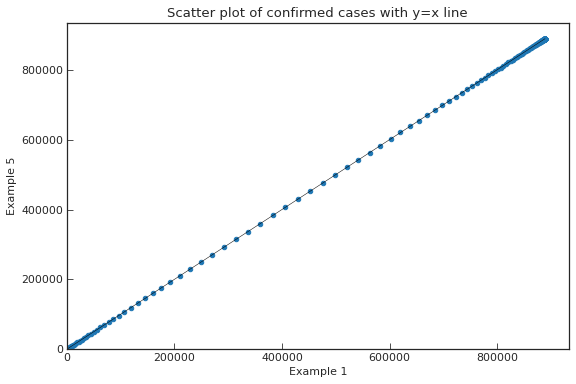

In [86]:
df = eg_ncov_df.pivot_table(index="Date", columns="Country", values="Confirmed")
df.plot.scatter(x="Example 1", y="Example 5")
plt.plot(df["Example 1"], df["Example 1"], color="black", linewidth=0.5)
plt.xlim(0, None)
plt.ylim(0, None)
plt.title("Scatter plot of confirmed cases with y=x line")
plt.show()

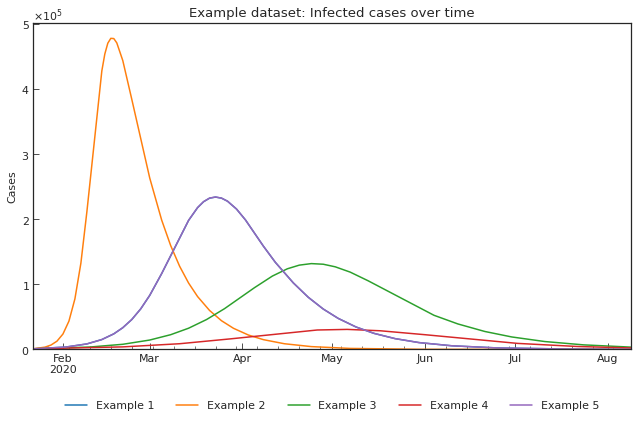

In [87]:
cs.line_plot(
    eg_ncov_df.pivot_table(index="Date", columns="Country", values="Infected"),
    "Example dataset: Infected cases over time"
)

Note: This seems Gamma distribution curve.
\begin{align*}
f(x>0) & = \cfrac{\lambda^{k}}{\Gamma(k)} x^{k-1} e^{-\lambda x}  \\
\Gamma(k) & = \int_{0}^{\infty} t^{k-1} e^{-t} dt
\end{align*}

Curve fitting with Gamma distribution curve is done by Bill Holst. Please find the URLs in ["Acknowledgement" subsection](#3).

## $\Delta$Confirmed vs. Confirmed in log-log plot
The numer of new confirmed cases $\Delta C$ can be desribed as,
\begin{align*}
\Delta C=N^{-1}\beta (N - C) I
\end{align*}
This is because $C=I+R+F$ and $S=N-C$ in SIR-F model.

$t$ is a measurable variable, but this is just an intermediate variable. $\Delta C$ is determined by cummurative number of cases.

In addition, $I$ is determined by $C$ when the parameters $(\alpha_1, \alpha_2, \beta, \gamma)$ are fixed.  
Then,
$$\Delta C = f(C)$$

Plots of $(x, y) = (C, \Delta C)$ in log-log scale are shown in the next figure.  

Note:  
This idea is from [YouTube: How To Tell If We're Beating COVID-19](https://www.youtube.com/watch?v=54XLXg4fYsc). SIR-type models are not mentioned in this video, but we can link the idea with SIR-F model as above.

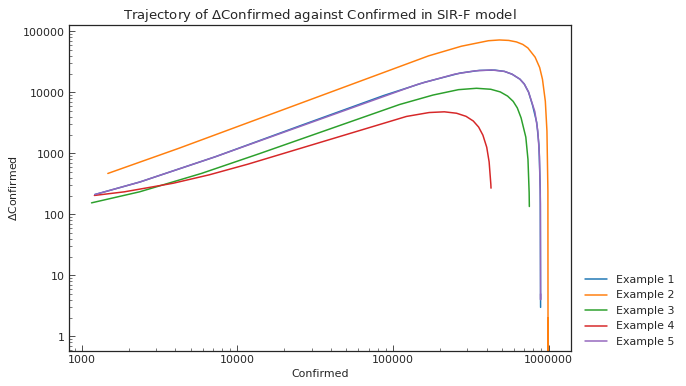

In [88]:
for country in eg_ncov_df["Country"].unique():
    df = eg_ncov_df.copy()
    df = df.loc[df["Country"] == country, :]
    df = df.groupby("Date").last()
    plt.plot(df["Confirmed"], df["Confirmed"].diff(), label=country)

plt.title(r"Trajectory of $\Delta$Confirmed against Confirmed in SIR-F model")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Confirmed")
plt.ylabel(r"$\Delta$Confirmed")
fmt = matplotlib.ticker.ScalarFormatter(useOffset=False)
fmt.set_scientific(False)
plt.gca().xaxis.set_major_formatter(fmt)
plt.gca().yaxis.set_major_formatter(fmt)
plt.legend(bbox_to_anchor=(1.02, 0), loc="lower left", borderaxespad=0)
plt.show()

Nete: Because $C(t)$ is a cummurative number, $C(t+\Delta t) \geq C(t)$ for all $t$ and $\Delta t > 0$.

## argmax($\Delta C$) in $(x, y) = (t, C(t))$ plot
What can we know from $(C, \Delta C)$ plot? Here, we will discuss max value of $\Delta C$.

When $\Delta C$ shows max value of $\Delta C$ in "Example 5" dataset (equal to SIR-D model), $t$ and $C(t)$ is

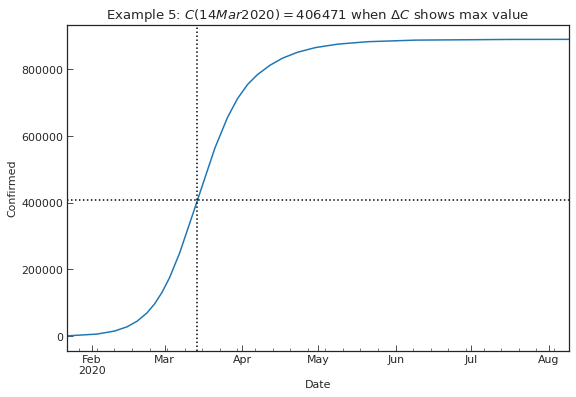

In [89]:
country = "Example 5"
df = eg_ncov_df.copy()
df = df.loc[df["Country"] == country, :].groupby("Date").last()
arg_tt = df["Confirmed"].diff().idxmax()
arg_cc = df.loc[arg_tt, "Confirmed"]
# Plot
df["Confirmed"].plot()
plt.axhline(y=arg_cc, color="black", linestyle=":")
plt.axvline(x=arg_tt, color="black", linestyle=":")
plt.ylabel("Confirmed")
plt.title(
    r'{0}: $C({1})={2}$ when $\Delta C$ shows max value'.format(
        country, arg_tt.strftime("%d%b%Y"), arg_cc)
)
fmt = matplotlib.ticker.ScalarFormatter(useOffset=False)
fmt.set_scientific(False)
plt.gca().yaxis.set_major_formatter(fmt)
plt.show()

## Curve fitting of $C(t)$
$C(t)$ is sometimes described by logistic function and Gompertz function.

\begin{align*}
\mathrm{Logistic\ function:\ } g(t) & = \cfrac{N}{1 + A e^{-Bt}}  \\
\mathrm{Gompertz\ function:\ } h(t) & = N e^{-A e^{-Bt}}
\end{align*}

cf.)  
These functions are used for prediction of the number of case in [Jia, Lin, et al., 2020](https://arxiv.org/ftp/arxiv/papers/2003/2003.05447.pdf).  

$f(t)$ can be divided to to stages;
* exponential growth function $(t \leq \mathrm{argmax}\ \Delta C(t))$ and
* negative exponential function $(otherwise)$.

With constant $(a, b, A, B, C)$,
$$
f(t) = \left\{
\begin{array}{ll}
    a e^{bt} & (t \leq \mathrm{argmax}\ \Delta C(t)) \\
    C - Ae^{-Bt} & (otherwise)
\end{array}
\right.
$$

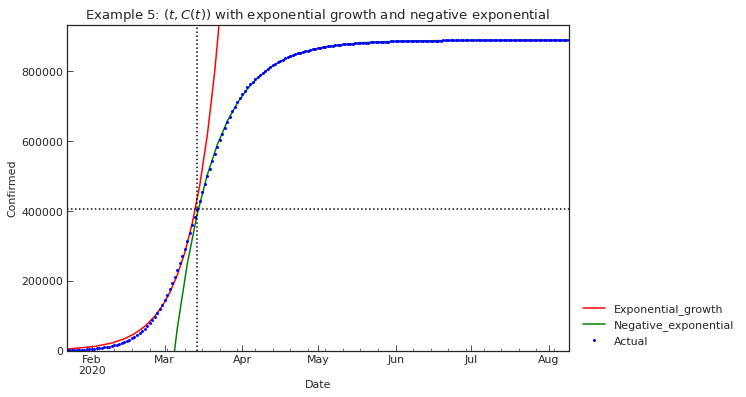

In [90]:
country = "Example 5"
df = eg_ncov_df.copy()
df = df.loc[df["Country"] == country, :].groupby("Date").last()
start_date = df.index.min()
arg_tt = df["Confirmed"].diff().idxmax()
arg_dd = int((arg_tt - start_date).total_seconds() / 60 / 60 / 24)
arg_cc = df.loc[arg_tt, "Confirmed"]
# Convert date to elapsed time (day)
df.index = ((df.index - start_date).total_seconds() / 60 / 60 / 24).astype(np.int64)
# Curve fitting with exponential growth function
f = lambda x, a, b: a * np.exp(b * x)
series = df.loc[df.index <= arg_dd, "Confirmed"]
a_ini = series[0]
b_ini = np.log(arg_cc / a_ini) / arg_dd
param, _ = sci.optimize.curve_fit(f, series.index, series, p0=[a_ini, b_ini])
f_partial = functools.partial(f, a=param[0], b=param[1])
df["Exponential_growth"] = pd.Series(df.index).apply(lambda x: f_partial(x))
# Curve fitting with negative exponential function
f = lambda x, a, b, c: c - a * np.exp(- b * (x - arg_dd))
series = df.loc[df.index >= arg_dd, "Confirmed"]
c_ini = series.max()
a_ini = c_ini - arg_cc
b_ini = series.diff()[arg_dd + 1] / a_ini
param, _ = sci.optimize.curve_fit(f, series.index, series, p0=[a_ini, b_ini, c_ini])
f_partial = functools.partial(f, a=param[0], b=param[1], c=param[2])
df["Negative_exponential"] = pd.Series(df.index).apply(lambda x: f_partial(x))
# Convert elapsed time (day) to date
df.index = start_date + pd.Series(df.index).apply(lambda x: timedelta(days=x))
# Plot
df[["Exponential_growth", "Negative_exponential"]].plot(color=["red", "green"])
df["Actual"] = df["Confirmed"]
df["Actual"].plot(color="blue", marker=".", markeredgewidth=0, linewidth=0)
plt.axhline(y=arg_cc, color="black", linestyle=":")
plt.axvline(x=arg_tt, color="black", linestyle=":")
plt.ylabel("Confirmed")
plt.ylim(0, max(df["Confirmed"]) * 1.05)
plt.title(r"{0}: $(t, C(t))$ with exponential growth and negative exponential".format(country))
fmt = matplotlib.ticker.ScalarFormatter(useOffset=False)
fmt.set_scientific(False)
plt.gca().yaxis.set_major_formatter(fmt)
plt.legend(bbox_to_anchor=(1.02, 0), loc="lower left", borderaxespad=0)
plt.show()

However, errors were found for curve fitting when $t \leq \mathrm{argmax}\ \Delta C(t)$.  
This is because
$$
\cfrac{\mathrm{d}C}{\mathrm{d}T} = \cfrac{\beta}{N} S I
$$
$S \simeq N: const.$ for $t \leq \mathrm{argmax}\ \Delta C(t)$, but $I$ is not proportinal to $C$ in SIR-like model.  

This means we cannot convert the differencial equation to the following equations.
\begin{align*}
\frac{\mathrm{d}x}{\mathrm{d}t} & = B x \\
\mathrm{i.e.\ } x(t) & = A e^{Bt}
\end{align*}

## S-R plane
Here, we will discuss the replationship of Susceptible and Recovered.

In SIR-F model,
\begin{align*}
\frac{\mathrm{d}S}{\mathrm{d}T} &= - \cfrac{\beta}{N} S I  \\
\frac{\mathrm{d}R}{\mathrm{d}T} &= \gamma I  \\
I &> 0 \\
S & \simeq N \ \mathrm{when}\ R = 0\\
\end{align*}

Then,
\begin{align*}
\cfrac{\mathrm{d}S}{\mathrm{d}R} &= - \cfrac{\beta}{N \gamma} S  \\
\end{align*}

This leads to

In [91]:
S = sym.symbols("S", cls=sym.Function)
N, R = sym.symbols("N R", positive=True)
beta, gamma = sym.symbols(r"\beta \gamma", positive=True)
dSdR = - beta / (N * gamma) * S(R)
sr = sym.dsolve(S(R).diff(R) - dSdR, hint="separable", ics={S(0): N})
sr

Eq(S(R), N*exp(-R*\beta/(N*\gamma)))

Note:  
This idea is from [Balkew, Teshome Mogessie, "The SIR Model When S(t) is a Multi-Exponential Function." (2010).Electronic Theses and Dissertations.Paper 1747.](https://dc.etsu.edu/cgi/viewcontent.cgi?article=3102&context=etd) This is for simplest SIR model, but we can apply it to SIR-F model.

In [92]:
sym.Eq(sym.simplify(sym.log(sr.lhs)), sym.simplify(sym.log(sr.rhs)))

Eq(log(S(R)), log(N) - R*\beta/(N*\gamma))

With constant $a=\frac{\beta}{N\gamma}$ and constant $b=\log N$,
$$
\log S_{(R)} = - a R + b
$$

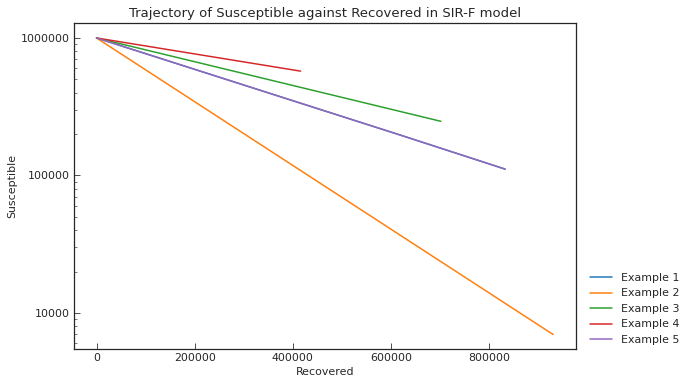

In [93]:
for country in eg_ncov_df["Country"].unique():
    df = eg_ncov_df.copy()
    df = df.loc[df["Country"] == country, :]
    df = df.groupby("Date").last()
    plt.plot(df["Recovered"], eg_population - df["Confirmed"], label=country)

plt.title(r"Trajectory of Susceptible against Recovered in SIR-F model")
plt.yscale("log")
plt.xlabel("Recovered")
plt.ylabel("Susceptible")
fmt = matplotlib.ticker.ScalarFormatter(useOffset=False)
fmt.set_scientific(False)
plt.gca().xaxis.set_major_formatter(fmt)
plt.gca().yaxis.set_major_formatter(fmt)
plt.legend(bbox_to_anchor=(1.02, 0), loc="lower left", borderaxespad=0)
plt.show()

Nete: Because $R(t)$ is a cummurative number, $R(t+\Delta t) \geq R(t)$ for all $t$ and $\Delta t > 0$.

**Thus, slope of $\log S_{(R)}$ will be changed when SIR-F parameters are changed. We need to split the actual data, considering the change points of S-R line in log-scale. This logic will be used for actual data in scenario analysis section.**

## S-R trend of actual data in one country
We will perform S-R trend analysis for actual data in Italy as an example.

Let's see the plot of S-R trend.

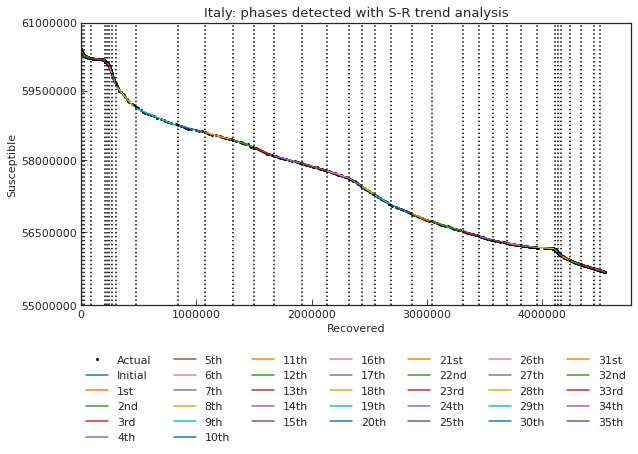

In [94]:
ita_scenario = cs.Scenario(country="Italy")
ita_scenario.register(jhu_data)
_ = ita_scenario.trend()

Plots of Actual data do not show a line. This means SIR-F parameters were changed at some time-points. In the next section, we will find the time-points, assuming that there are four change points in Italy dataset.

# Scenario in Italy<a id="7"></a>
In this section, we will perform scenario analysis using the records of Italy.

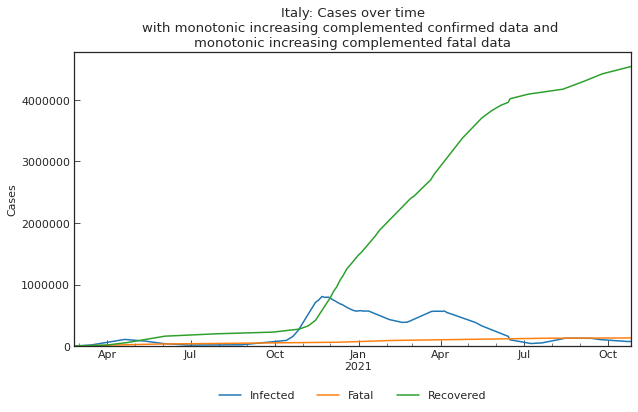

,Date,Infected,Fatal,Recovered
607,2021-10-23,74016,131802,4531644
608,2021-10-24,74775,131826,4534584
609,2021-10-25,74654,131856,4537210
610,2021-10-26,75046,131904,4540823
611,2021-10-27,75365,131954,4545049


In [95]:
# ita_scenario = cs.Scenario(country="Italy")
# ita_scenario.register(jhu_data, population_data)
ita_scenario.records().tail()

## S-R Trend analysis

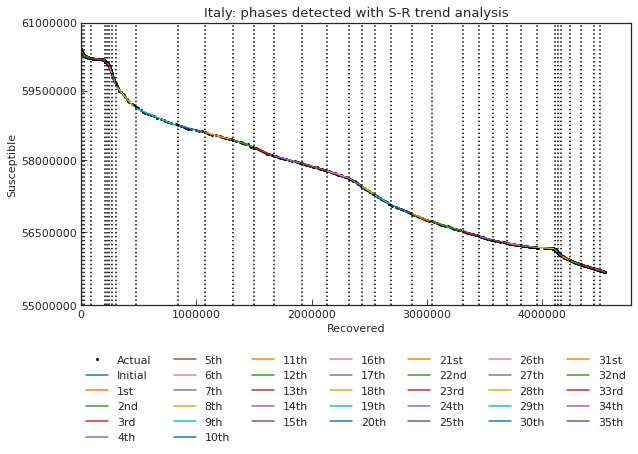

In [96]:
_ = ita_scenario.trend()

## Phases in Italy
We will use the change points as the start date of phases. For each phase, will apply SIR-F model. $\tau$ values will be the same value.

In [97]:
ita_scenario.summary()

,Type,Start,End,Population
0th,Past,24Feb2020,22Mar2020,60421760
1st,Past,23Mar2020,10Apr2020,60421760
2nd,Past,11Apr2020,05May2020,60421760
3rd,Past,06May2020,28Aug2020,60421760
4th,Past,29Aug2020,25Sep2020,60421760
5th,Past,26Sep2020,12Oct2020,60421760
6th,Past,13Oct2020,26Oct2020,60421760
7th,Past,27Oct2020,03Nov2020,60421760
8th,Past,04Nov2020,17Nov2020,60421760
9th,Past,18Nov2020,02Dec2020,60421760


## Estimate SIR-F parameters

In [98]:
ita_scenario.estimate(cs.SIRF, timeout=120)


<SIR-F model: parameter estimation>
Running optimization with 4 CPUs...
	 6th phase (13Oct2020 - 26Oct2020): finished  129 trials in 0 min  5 sec
	 9th phase (18Nov2020 - 02Dec2020): finished  131 trials in 0 min  5 sec
	 0th phase (24Feb2020 - 22Mar2020): finished  263 trials in 0 min 12 sec
	 7th phase (27Oct2020 - 03Nov2020): finished  177 trials in 0 min  8 sec
	10th phase (03Dec2020 - 11Dec2020): finished  186 trials in 0 min  8 sec
	11th phase (12Dec2020 - 22Dec2020): finished  105 trials in 0 min  4 sec
	 1st phase (23Mar2020 - 10Apr2020): finished  149 trials in 0 min  6 sec
	 3rd phase (06May2020 - 28Aug2020): finished  386 trials in 0 min 20 sec
	12th phase (23Dec2020 - 02Jan2021): finished  141 trials in 0 min  6 sec
	13th phase (03Jan2021 - 12Jan2021): finished   31 trials in 0 min  1 sec
	 4th phase (29Aug2020 - 25Sep2020): finished  126 trials in 0 min  5 sec
	14th phase (13Jan2021 - 25Jan2021): finished   51 trials in 0 min  2 sec
	15th phase (26Jan2021 - 07Feb2021): fi

### Compare parameters

In [99]:
ita_scenario.summary()

,Type,Start,End,Population,ODE,Rt,theta,kappa,rho,sigma,tau,alpha1 [-],1/alpha2 [day],1/beta [day],1/gamma [day],RMSLE,Trials,Runtime
0th,Past,24Feb2020,22Mar2020,60421760,SIR-F,7.66,0.030976,0.008280,0.268516,0.025700,1440,0.031,120,3,38,0.382743,263,0 min 12 sec
1st,Past,23Mar2020,10Apr2020,60421760,SIR-F,2.68,0.018942,0.009642,0.071744,0.016585,1440,0.019,103,13,60,0.058063,149,0 min 6 sec
2nd,Past,11Apr2020,05May2020,60421760,SIR-F,1.09,0.063774,0.002755,0.027407,0.020797,1440,0.064,363,36,48,0.033378,271,0 min 12 sec
3rd,Past,06May2020,28Aug2020,60421760,SIR-F,0.31,0.103208,0.000494,0.011209,0.031788,1440,0.103,2024,89,31,0.231920,386,0 min 20 sec
4th,Past,29Aug2020,25Sep2020,60421760,SIR-F,2.82,0.001056,0.000452,0.044569,0.015364,1440,0.001,2211,22,65,0.024925,126,0 min 5 sec
5th,Past,26Sep2020,12Oct2020,60421760,SIR-F,2.51,0.000015,0.000421,0.045688,0.017771,1440,0.000,2377,21,56,0.029597,275,0 min 12 sec
6th,Past,13Oct2020,26Oct2020,60421760,SIR-F,5.95,0.000025,0.000509,0.090527,0.014705,1440,0.000,1963,11,68,0.012139,129,0 min 5 sec
7th,Past,27Oct2020,03Nov2020,60421760,SIR-F,8.00,0.000177,0.000759,0.087592,0.010182,1440,0.000,1317,11,98,0.012532,177,0 min 8 sec
8th,Past,04Nov2020,17Nov2020,60421760,SIR-F,3.27,0.000650,0.000790,0.064386,0.018868,1440,0.001,1265,15,52,0.020681,455,0 min 24 sec
9th,Past,18Nov2020,02Dec2020,60421760,SIR-F,1.19,0.000093,0.000945,0.038085,0.031019,1440,0.000,1057,26,32,0.021232,131,0 min 5 sec


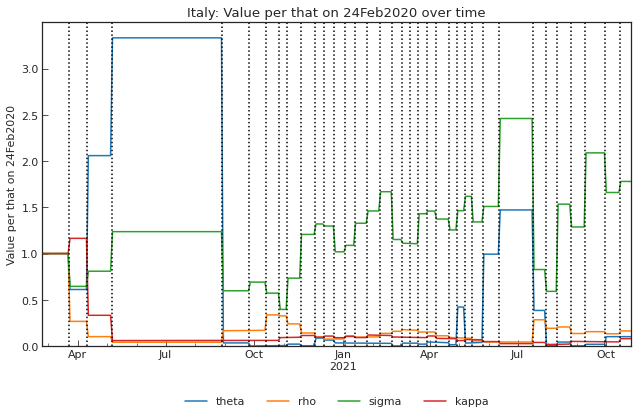

In [100]:
_ = ita_scenario.history_rate()

**Non-dimensional effective contact rate $\rho$ was reduced in phases.**

## Why $\rho$ was reduced?

Measures taken in Italy are shown here.

In [101]:
def _color(data_df):
    df = data_df.copy()
    df.loc[:, :] = str()
    df.iloc[[3, 6, 8], :] = "background-color: lightgreen"
    return df

ita_action_df.style.apply(_color, axis=None)

,Region,Start_date,End_date,Action,Detail,Number_of_people
0,-,2020-01-30 00:00:00,NaT,Restriction of entry,All flights to and from China have been suspended,-1
1,-,2020-02-03 00:00:00,NaT,Leave from epidemic area,Return of people present in countries at risk and return of foreign citizens to the countries of origin exposed to the risk,-1
2,-,2020-02-06 00:00:00,NaT,Control in the Airport,Airport monitoring and control for domestic and international flights,62000
3,-,2020-02-21 00:00:00,2020-02-21 00:00:00,Quaranteene,"Mandatory quarantine isolation for close contacts with a positive cases, and provides active surveillance with fiduciary home permanence for those who have been in risk areas in the last 14 days",-1
4,"Lombardia,Veneto",2020-02-23 00:00:00,NaT,containment and management the Italian infected areas,decree-law introducing urgent measures regarding the containment and management of the epidemiological emergency from COVID-2019.,53856‬
5,"Emilia Romagna,Friuli Venezia Giulia, Lombardia, Veneto, Piemonte e Liguria,",2020-02-25 00:00:00,NaT,containment and management the Italian infected areas,decree-law introducing urgent measures regarding the containment and management of the epidemiological emergency from COVID-2019.,37447171‬
6,All,2020-03-04 00:00:00,2020-03-15 00:00:00,Close school and university,relative decree-law containing further measures to combat and contain the spread of the COVID-19 virus throughout the country,8466064
7,"Emilia Romagna,Friuli Venezia Giulia, Lombardia, Veneto, Piemonte e Liguria,",2020-03-07 00:00:00,2020-03-07 00:00:00,more containment and management the Italian infected areas,"prohibit any movement in Lombardy and in fourteen provinces of Veneto, Emilia Romagna, Piedmont, Marche.",-1
8,-,2020-03-09 00:00:00,2020-05-04 00:00:00,lockdown,people must stay at home and go out only for food or work needs. Many activities are closed and only the essential ones remain open.,60483973
9,-,2020-03-19 00:00:00,NaT,Medicine sperimentation,"testing began on the drug Tocilizumab, a drug used against rheumatoid arthritis that has had beneficial effects against COVID-19 in China.",330


**It seems that (quaranitine of person contacted with positive patients), school closure and lockdown reduced $\rho$ value.**

## Effect of school closure and lockdown

Acording to first report of [COVID-19 Mobility Monitoring project](https://covid19mm.github.io/in-progress/2020/03/13/first-report-assessment.html) on 13Mar2020, the government of Italy declared a national lockdown on 09Mar2020 and all peole are asked to remain home. This resulted in average reduction of potential encounters of 19% during week 3 (from 07Mar2020 to 10Mar2020).

**Here, we will predict the effect of school closure (started before 04Mar2020), lockdown on 13Mar2020 with assumtion that the effect will be shown from the start date of 3rd phase.**

In [102]:
ita_scenario.get("Start", name="Main", phase="3rd")

'06May2020'

### Real factors of $\beta_1$

The parameter in the math model:  
\begin{align*}
\rho_1 & = \tau \beta_1  \\  
\beta_1 & = \cfrac{1}{49}[g_s \{g_w + g_i (1-q) \} v (1-m)^2 (1-w_e)^{w_n} e^{-(h_{1}+h_{2})} c \delta]  \\
\end{align*}

Control factors:  
$g_s$: **The number of days in <u>a week</u> susceptible persons go out [day]**  
$g_w$: The number of days in <u>a week</u> waiting but un-quarantined persons go out [day]  
$g_i$: The number of days in <u>a week</u> currently infected (confirmed) but un-quarantined persons go out [day]  
$q$: Quarantine rate of currently infected (confirmed) patients [-]  
$v$: Probability of virus existance in a droplet [-]  
$m$: Rate of persons wearing masks effectively (depends logistically on supply of masks) [-]  
$w_e$: Virus reduction effect of washing hands [-]  
$w_n$: The number of times people washes their hands before touching their own faces after go out [-]  
$h_1$: Health condition (active rate of cellular immunity factors) of susceptible and contacted persons [-]  
$h_2$: Health condition (active rate of humoral immunity factors) of susceptible and contacted persons [-]  
$c$: **The number of contacts between susceptible persons and patients while on the go in a minute (depends on population density) [1/min]**  
$\delta$:The product of unknown real factors [-]  

### Value of control factors of $\beta_1$ before/after the national lockdown
A national lockdown will effect on $g_s$ and $c$.

Acccoring the report, we assume average reduction of potential encounters ($c$[-]) of 19%.

In [103]:
c_before, c_after = 1.0, 0.81

### $g_s$ before the lockdown
We will estimate average number peple go out using @marcoferrante estimation table and population pyramid data.
It is necessary to replace the population pyramid data for Italy because the situation is different from the average data.

In [104]:
ita_out_df = go_out("Italy")
ita_out_df

,Age_first,Age_last,Period_of_life,School,Office,Others,Age,Population,Portion
0,0,2,nursery,3,0,0,2,1373871,0.025722
1,3,5,nursery school,4,0,1,5,1441955,0.026997
2,6,10,elementary school,5,0,1,10,2667055,0.049933
3,11,13,middle school,5,0,1,13,1688673,0.031616
4,14,18,high school,6,0,1,18,2829215,0.052969
5,19,25,university/work,3,3,1,25,4087599,0.076529
6,26,35,work,0,6,1,35,6521421,0.122096
7,36,45,work,0,5,1,45,7940871,0.148671
8,46,55,work,0,5,1,55,9560703,0.178998
9,56,65,work,0,5,1,65,8261046,0.154666


In [105]:
df = ita_out_df.copy()
gs_before = (df[["School", "Office", "Others"]].sum(axis=1) * df["Portion"]).sum()
print(f"{round(gs_before, 1)} days in a week susceptible people go out.")

5.8 days in a week susceptible people go out.


### Estimation of $g_s$ after school closure/lockdown
Here, we estimate the $g_s$ after school closure/lockdown with the assumption that only $g_s$ and $c$ was changed.   

Because
$$\cfrac{\rho_{\mathrm{after}}}{gs_{\mathrm{after}}\times c_{\mathrm{after}}} = \cfrac{\rho_{\mathrm{before}}}{gs_{\mathrm{before}}\times c_{\mathrm{before}}}$$

$gs_{\mathrm{after}}$ is

In [106]:
rho_before = ita_scenario.get("rho", name="Main", phase="1st")
rho_after = ita_scenario.get("rho", name="Main", phase="3rd")
gs_after = rho_after / rho_before / c_after * gs_before * c_before
print(f"{round(gs_after, 1)} days in a week susceptible people go out after lockdown.")

1.1 days in a week susceptible people go out after lockdown.


Let's apply this value to the go_out table!  
We assume that workers go to their office one day in a week.

In [107]:
df = ita_out_df.copy()
df["School"] = 0
df.loc[df["Office"] > 0, "Office"] = 1
sum_so = (df[["School", "Office"]].sum(axis=1) * df["Portion"]).sum()
df.loc[df["Others"] > 0, "Others"] = round(gs_after - sum_so, 1)
ita_out_after_df = df.copy()
ita_out_after_df

,Age_first,Age_last,Period_of_life,School,Office,Others,Age,Population,Portion
0,0,2,nursery,0,0,0.0,2,1373871,0.025722
1,3,5,nursery school,0,0,0.4,5,1441955,0.026997
2,6,10,elementary school,0,0,0.4,10,2667055,0.049933
3,11,13,middle school,0,0,0.4,13,1688673,0.031616
4,14,18,high school,0,0,0.4,18,2829215,0.052969
5,19,25,university/work,0,1,0.4,25,4087599,0.076529
6,26,35,work,0,1,0.4,35,6521421,0.122096
7,36,45,work,0,1,0.4,45,7940871,0.148671
8,46,55,work,0,1,0.4,55,9560703,0.178998
9,56,65,work,0,1,0.4,65,8261046,0.154666


Check the $g_s$ value calculated with the table.

In [108]:
df = ita_out_after_df.copy()
gs_after2 = (df[["School", "Office", "Others"]].sum(axis=1) * df["Portion"]).sum()
print(f"{round(gs_after2, 1)} days in a week susceptible people go out after lockdown.")

1.1 days in a week susceptible people go out after lockdown.


## Predict the future with the last parameters

In a week,

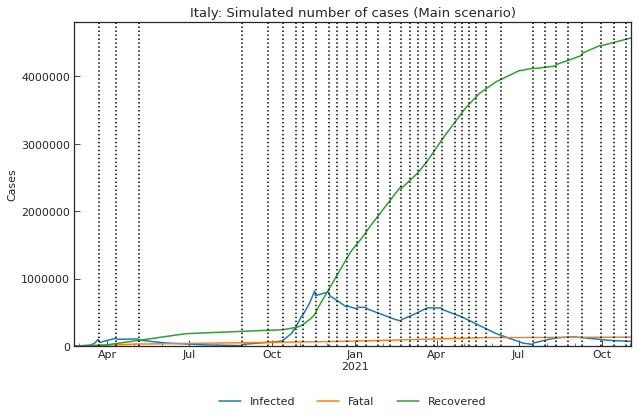

,Date,Infected,Fatal,Recovered
612,2021-10-28 00:00:00,72220,132334,4550691
613,2021-10-29 00:00:00,71789,132391,4553984
614,2021-10-30 00:00:00,71360,132447,4557258
615,2021-10-31 00:00:00,70933,132503,4560512
616,2021-11-01 00:00:00,70509,132559,4563746
617,2021-11-02 00:00:00,70087,132614,4566961
618,2021-11-03 00:00:00,69668,132669,4570157


In [109]:
ita_scenario.clear()
ita_scenario.add(days=7)
ita_scenario.simulate().tail(7).style.background_gradient(axis=0)

In 30 days,

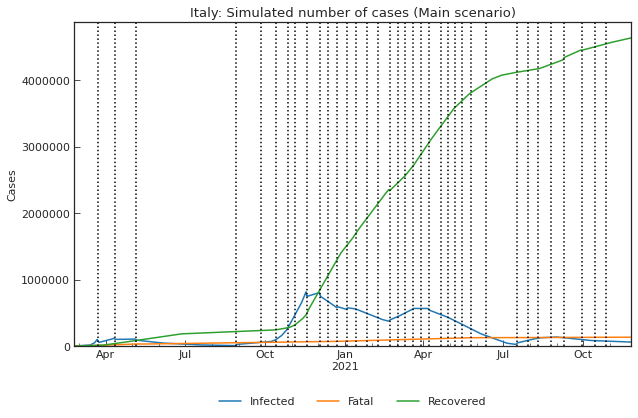

,Date,Infected,Fatal,Recovered
635,2021-11-20 00:00:00,62890,133557,4621647
636,2021-11-21 00:00:00,62511,133606,4624514
637,2021-11-22 00:00:00,62135,133655,4627365
638,2021-11-23 00:00:00,61761,133704,4630198
639,2021-11-24 00:00:00,61389,133752,4633014
640,2021-11-25 00:00:00,61019,133801,4635813
641,2021-11-26 00:00:00,60651,133849,4638596


In [110]:
ita_scenario.clear()
ita_scenario.add(days=30)
ita_scenario.simulate().tail(7).style.background_gradient(axis=0)

In the long-term,

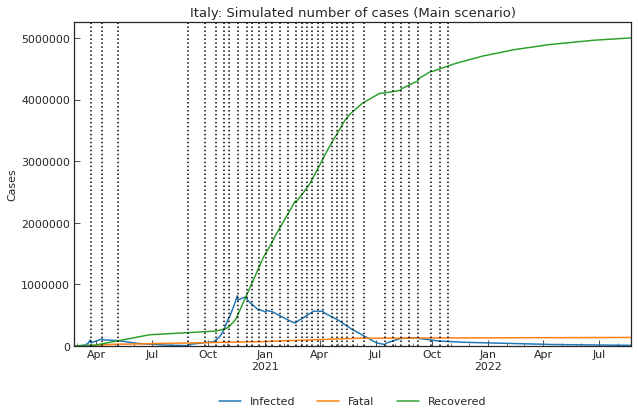

In [111]:
ita_scenario.clear()
ita_scenario.add(days=300)
_ = ita_scenario.simulate()

## Effect of expected new medicines
New medicines are necessary so that patients can recover more quicky from the disease. Drug repositioning strategy (i.e.finding effective candidates from library of existing drugs of different diseases) is used to develop the medicines of COVID-19. For example, Remdesivir (USAN) and Favipiravir (AVIGAN) are candidates. 

* KEGG DRUG DATABASE: [Remdesivir (USAN)](https://www.kegg.jp/dbget-bin/www_bget?dr:D11472), Antiviral.
* KEGG DRUG DATABASE: [Favipiravir (AVIGAN)](https://www.kegg.jp/dbget-bin/www_bget?dr:D09537), efficancy is Antiviral, RNA replicase inhibitor.

Certainly, Favipiravir (AVIGAN) may lead many serious adverse reactions and it cannot be provided to expectant mothers [KEGG database AVIGAN](https://www.kegg.jp/medicus-bin/japic_med?japic_code=00066852) (Sorry, this is written in Japanese). However, it may help to save many thousand lives.  

Un-controlled clinical study of Remdesivir from 25Jan2020 to 07Mar2020:  
According to [Grein, Jonathan, et al., 2020](https://www.nejm.org/doi/full/10.1056/NEJMoa2007016?query=RP), 10-day course of Remdesivir administration (200 mg at day 1 followed by 100 mg daily) with median foloow-up of 18 days were performed.  

53 patients in the full analysis set were those with confirmed infection and had oxygen satulation of 94% or less while they were breathing ambient air or receiving oxygen support. They are from USA (22 patients), Europe/Canada (22 patients) and Japan (9 patients). 36 patients (68%) showed clinical improvement. 25 patients (47%) was discharged, 7 patients (13%) deceased.

clinical trial with placebo is necessary for evaluation, but we can assume $\gamma$ and $\alpha$ as follows. (This estimation is not refered in this paper. This just a rough evaluation.)
<!--
\begin{align*}
& \kappa \tau^{-1} = \alpha_2 = \cfrac{\bar{h}\ \bar{s}}{N} \sum_{n=0}^{\infty}\cfrac{P_{i}}{L_i} \\
& \sigma \tau^{-1} = \gamma = \cfrac{1 - \bar{h}\ \bar{s}}{N} \sum_{n=0}^{\infty}\cfrac{P_{i}}{l_i} \\
\end{align*}
$\bar{h}$: Rate of I whose immune systems does NOT overcame virus multiplication [-]  
$\bar{s}$: Rate of I$^\star$ who have severe events, including respiratory failure  [-]  
$L_i$: Inverse of F$^\star$'s mortality rate for people $i$ years old [min]  
$l_i$: Inverse of R$^\star$'s mortality rate for people $i$ years old [min]  
$P_i$: The number of people $i$ years old [-]  
$N$: Total population  
-->

$$
\gamma_{med} = \cfrac{\tau \times(\mathrm{Percentage\ of\ discharged)}}{\mathrm{Total\ number\ of\ minutes\ with\ obserbvation}}
$$

In [112]:
sigma_before = ita_scenario.get("sigma", name="Main", phase="3rd")
kappa_before = ita_scenario.get("kappa", name="Main", phase="3rd")
(sigma_before, kappa_before)

(0.031787911023475064, 0.0004939919462503022)

In [113]:
# Tentative evaluation with clinical study
sigma_med = ita_scenario.get("tau", name="Main", phase="3rd") * (25 / 53) / ((10 + 18) * 1440)
kappa_med = ita_scenario.get("tau", name="Main", phase="3rd") * (7 / 53) / ((10 + 18) * 1440)
(sigma_med, kappa_med)

(0.016846361185983826, 0.0047169811320754715)

In three 90 days,

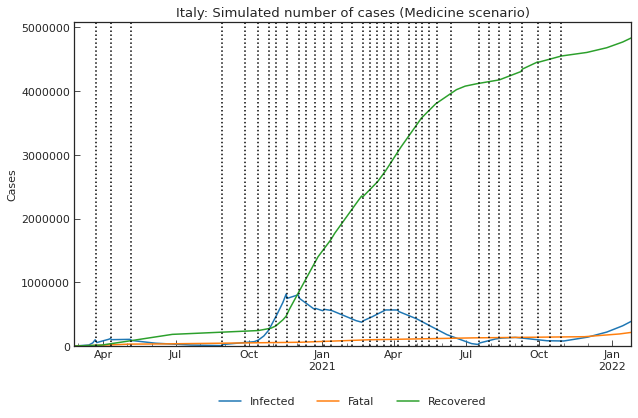

,Date,Infected,Fatal,Recovered
695,2022-01-19 00:00:00,348949,204124,4797254
696,2022-01-20 00:00:00,355434,205831,4803190
697,2022-01-21 00:00:00,362035,207569,4809236
698,2022-01-22 00:00:00,368755,209339,4815394
699,2022-01-23 00:00:00,375594,211142,4821666
700,2022-01-24 00:00:00,382556,212979,4828053
701,2022-01-25 00:00:00,389642,214849,4834558


In [114]:
ita_scenario.clear(name="Medicine")
ita_scenario.add(days=90, name="Medicine", kappa=kappa_med, sigma=sigma_med)
ita_scenario.simulate(name="Medicine").tail(7).style.background_gradient(axis=0)

In the long-term,

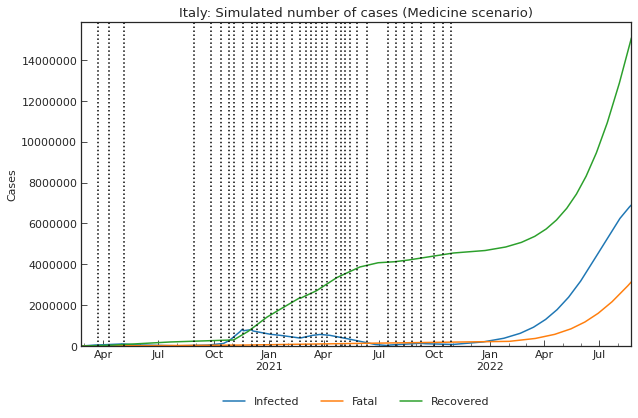

In [115]:
ita_scenario.clear(name="Medicine")
ita_scenario.add(days=300, name="Medicine", kappa=kappa_med, sigma=sigma_med)
_ = ita_scenario.simulate(name="Medicine")

# Scenario in Japan<a id="8"></a>
In this section, we will perform scenario analysis using the records of Japan.

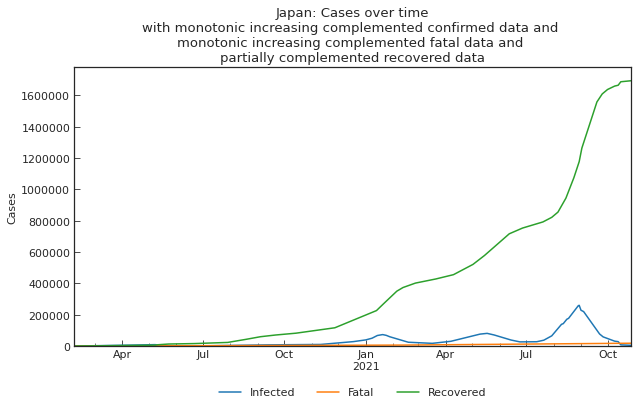

,Date,Infected,Fatal,Recovered
626,2021-10-24,4834,18191,1692985
627,2021-10-25,4624,18206,1693180
628,2021-10-26,4727,18221,1693374
629,2021-10-27,4396,18228,1694010
630,2021-10-28,4661,18237,1694010


In [116]:
jpn_scenario = cs.Scenario(country="Japan")
jpn_scenario.register(jhu_data)
jpn_scenario.records().tail()

## S-R Trend analysis

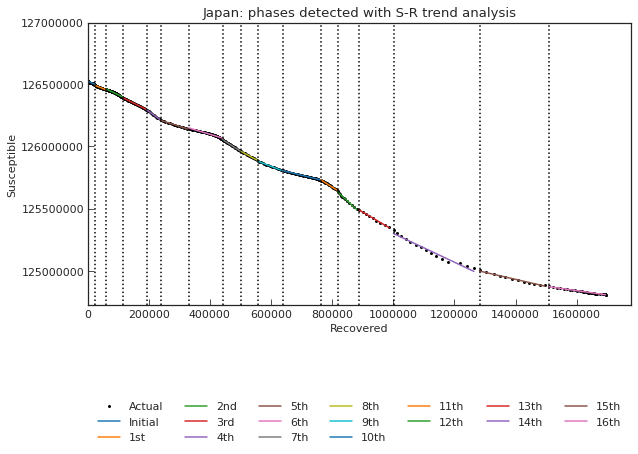

In [117]:
_ = jpn_scenario.trend()

## Phase in Japan
We will use the change points as the start date of phases. For each phase, will apply SIR-F model. $\tau$ values will be the same value.

In [118]:
jpn_scenario.summary()

,Type,Start,End,Population
0th,Past,06Feb2020,29Jul2020,126529100
1st,Past,30Jul2020,05Sep2020,126529100
2nd,Past,06Sep2020,26Nov2020,126529100
3rd,Past,27Nov2020,01Jan2021,126529100
4th,Past,02Jan2021,15Jan2021,126529100
5th,Past,16Jan2021,31Jan2021,126529100
6th,Past,01Feb2021,31Mar2021,126529100
7th,Past,01Apr2021,26Apr2021,126529100
8th,Past,27Apr2021,10May2021,126529100
9th,Past,11May2021,24May2021,126529100


## Estimate SIR-F parameters

In [119]:
jpn_scenario.estimate(cs.SIRF, timeout=120)


<SIR-F model: parameter estimation>
Running optimization with 4 CPUs...
	 2nd phase (06Sep2020 - 26Nov2020): finished  100 trials in 0 min  4 sec
	 0th phase (06Feb2020 - 29Jul2020): finished   95 trials in 0 min  4 sec
	 4th phase (02Jan2021 - 15Jan2021): finished  148 trials in 0 min  6 sec
	 1st phase (30Jul2020 - 05Sep2020): finished  153 trials in 0 min  6 sec
	 3rd phase (27Nov2020 - 01Jan2021): finished  256 trials in 0 min 11 sec
	 6th phase (01Feb2021 - 31Mar2021): finished  376 trials in 0 min 18 sec
	 8th phase (27Apr2021 - 10May2021): finished  314 trials in 0 min 14 sec
	10th phase (25May2021 - 02Jul2021): finished  230 trials in 0 min 10 sec
	 7th phase (01Apr2021 - 26Apr2021): finished  252 trials in 0 min 11 sec
	11th phase (03Jul2021 - 28Jul2021): finished  144 trials in 0 min  6 sec
	 9th phase (11May2021 - 24May2021): finished  195 trials in 0 min  8 sec
	 5th phase (16Jan2021 - 31Jan2021): finished  539 trials in 0 min 29 sec
	16th phase (15Sep2021 - 28Oct2021): fi

### Compare parameters

In [120]:
jpn_scenario.summary()

,Type,Start,End,Population,ODE,Rt,theta,kappa,rho,sigma,tau,alpha1 [-],1/alpha2 [day],1/beta [day],1/gamma [day],RMSLE,Trials,Runtime
0th,Past,06Feb2020,29Jul2020,126529100,SIR-F,1.19,0.103467,0.000218,0.115413,0.086637,720,0.103,2293,4,5,1.284390,95,0 min 4 sec
1st,Past,30Jul2020,05Sep2020,126529100,SIR-F,1.03,0.000110,0.000948,0.111382,0.106982,720,0.000,527,4,4,0.283310,153,0 min 6 sec
2nd,Past,06Sep2020,26Nov2020,126529100,SIR-F,0.99,0.000622,0.000735,0.070188,0.070290,720,0.001,680,7,7,0.271064,100,0 min 4 sec
3rd,Past,27Nov2020,01Jan2021,126529100,SIR-F,1.07,0.000174,0.000838,0.086289,0.079966,720,0.000,596,5,6,0.129311,256,0 min 11 sec
4th,Past,02Jan2021,15Jan2021,126529100,SIR-F,1.46,0.001443,0.000791,0.072784,0.049037,720,0.001,631,6,10,0.062706,148,0 min 6 sec
5th,Past,16Jan2021,31Jan2021,126529100,SIR-F,0.92,0.000114,0.000758,0.060232,0.065048,720,0.000,659,8,7,0.063614,539,0 min 29 sec
6th,Past,01Feb2021,31Mar2021,126529100,SIR-F,0.82,0.000220,0.001311,0.061602,0.073592,720,0.000,381,8,6,0.205352,376,0 min 18 sec
7th,Past,01Apr2021,26Apr2021,126529100,SIR-F,1.33,0.000225,0.000510,0.073758,0.055079,720,0.000,979,6,9,0.035852,252,0 min 11 sec
8th,Past,27Apr2021,10May2021,126529100,SIR-F,1.16,0.000148,0.000637,0.073501,0.062692,720,0.000,784,6,7,0.036960,314,0 min 14 sec
9th,Past,11May2021,24May2021,126529100,SIR-F,1.02,0.000095,0.000964,0.072422,0.069739,720,0.000,518,6,7,0.048831,195,0 min 8 sec


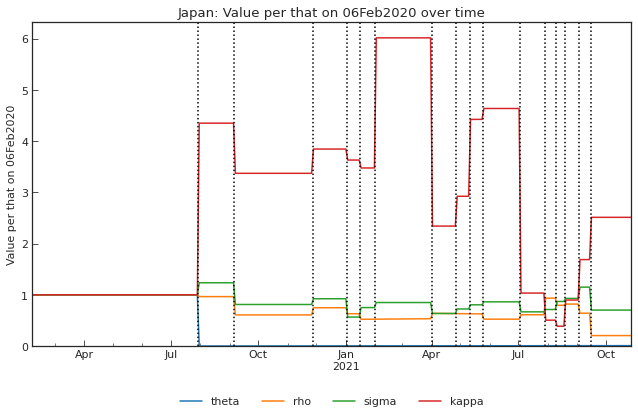

In [121]:
_ = jpn_scenario.history_rate()

Tokyo 2020 Olympics was postponed until 2021, and $\rho$ is decreasing from 2nd phase to 3rd phase.

## Why $\rho$ was decreased?
Japan declared a state of emergency three times.
* 07Apr2020 - 15APr2020: Only three metropolitan areas (Tokyo/Kanagawa/Saitama/Chiba, Osaka/Hyogo, Fukuoka)
* 16Apr2020 - 06May2020: Nation-wide
* 07May2020 - (31May2020): Nation-wide

However, national/city lock is not be done. Japan is mainly taking the following three actions.

* Physical (social) distancing: to avoid closed spaces, crowd, conversation at close distance
* Trace the link of patients and give tests on the linked persons preferentially
* Maintain medical level to increase recovery rate and decrease mortality rate

## Why $\sigma$ was decreased?

In [122]:
sigma2 = jpn_scenario.get("sigma", name="Main", phase="2nd")
sigma1 = jpn_scenario.get("sigma", name="Main", phase="1st")
sigma2 / sigma1

0.6570202434585443

## Predict the future with the last parameters

In a week,

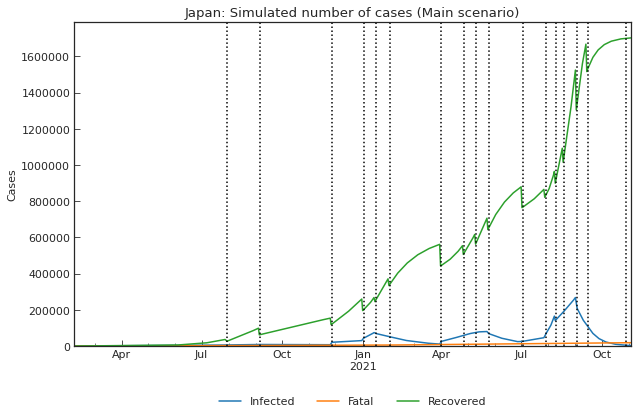

,Date,Infected,Fatal,Recovered
631,2021-10-29 00:00:00,3877,18683,1700438
632,2021-10-30 00:00:00,3592,18687,1700892
633,2021-10-31 00:00:00,3329,18691,1701313
634,2021-11-01 00:00:00,3084,18695,1701703
635,2021-11-02 00:00:00,2858,18698,1702064
636,2021-11-03 00:00:00,2648,18701,1702399
637,2021-11-04 00:00:00,2549,18703,1702557


In [123]:
jpn_scenario.clear()
jpn_scenario.add(days=7)
jpn_scenario.simulate().tail(7).style.background_gradient(axis=0)

In 30 days,

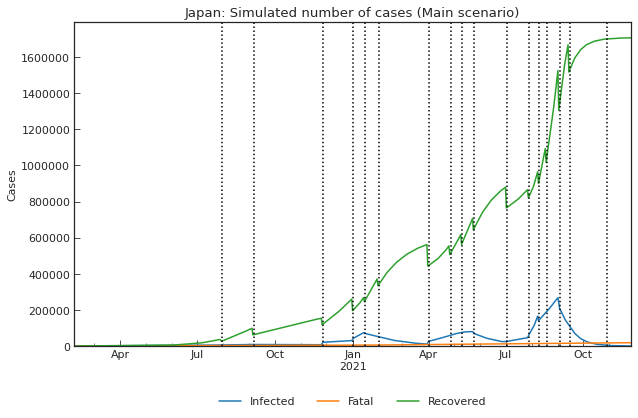

,Date,Infected,Fatal,Recovered
654,2021-11-21 00:00:00,673,18731,1705552
655,2021-11-22 00:00:00,624,18732,1705631
656,2021-11-23 00:00:00,578,18732,1705704
657,2021-11-24 00:00:00,536,18733,1705771
658,2021-11-25 00:00:00,496,18733,1705834
659,2021-11-26 00:00:00,460,18734,1705892
660,2021-11-27 00:00:00,443,18734,1705920


In [124]:
jpn_scenario.clear()
jpn_scenario.add(days=30)
jpn_scenario.simulate().tail(7).style.background_gradient(axis=0)

In the logn-term,

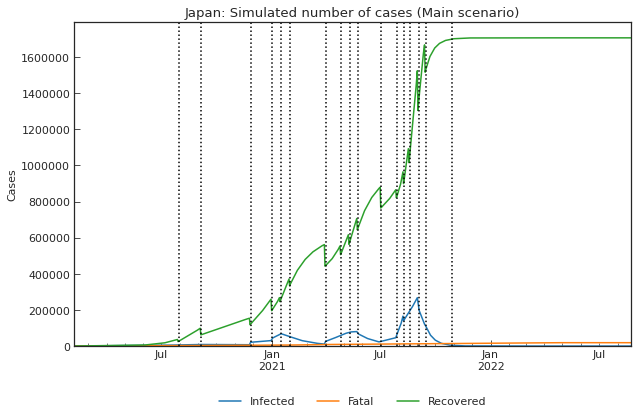

In [125]:
jpn_scenario.clear()
jpn_scenario.add(days=300)
_ = jpn_scenario.simulate()

## How to make way by 31May2020 for the number of cases peaking out
We assume today is in the second phase.

### The current situation
Under the assumtion that the current trend continues, when will the number of currently infected cases peak out?  
We can use $R_t$ as the index. When $R_t < 1$, $\frac{\mathrm{d}y}{\mathrm{d}t} < 0$.

This is because  
\begin{align*}
& \frac{\mathrm{d}y}{\mathrm{d}t}= \rho (1-\theta) x y - (\sigma + \kappa) y\\
& R_t = \rho (1 - \theta) (\sigma + \kappa)^{-1}\\
& x \simeq 1 \\
\end{align*}

where $R_t$ is reproduction number (phase/time-dependent version of $R_0$).

$x$ is

In [126]:
df = jhu_data.subset("Japan")
population_jpn = int(df.set_index("Date").sum(axis=1).median())
1 - df.loc[df.index[-1], "Confirmed"] / population_jpn

0.9864507619439954

The current value of $R_t$ is

In [127]:
jpn_scenario.get("Rt", name="Main", phase="2nd")

0.99

The number of currently infected cases will peak on

In [128]:
jpn_scenario.clear()
jpn_scenario.add(days=1000)
df = jpn_scenario.simulate(show_figure=False)
df.loc[df["Infected"].idxmax(), "Date"]

Timestamp('2021-09-01 00:00:00')

### How to set $R_t < 1$ by 31May2020
$R_t < 1$ when $\rho$ is under

In [129]:
current_rho = jpn_scenario.get("rho", name="Main", phase="last")
limit_rho = current_rho / jpn_scenario.get("Rt", name="Main", phase="last") * 1.0
limit_rho

0.0621196270532011

Here, we assume $\rho$ is

In [130]:
jpn_tau = jpn_scenario.get("tau", name="Main", phase="last")
beta_inv = math.ceil(jpn_tau / 24 / 60 / limit_rho) + 1
target_rho = jpn_tau / 24 / 60 / beta_inv
target_rho

0.05

In [131]:
target_rho < limit_rho

True

Set $\rho$ with the assumtion that $\rho$ will decrease,

In [132]:
jpn_scenario.clear()
jpn_scenario.add(days=60, rho=target_rho)
jpn_scenario.summary()

,Type,Start,End,Population,ODE,Rt,theta,kappa,rho,sigma,tau,alpha1 [-],1/alpha2 [day],1/beta [day],1/gamma [day],RMSLE,Trials,Runtime
0th,Past,06Feb2020,29Jul2020,126529100,SIR-F,1.19,0.103467,0.000218,0.115413,0.086637,720,0.103,2293.0,4.0,5.0,1.28439,95.0,0 min 4 sec
1st,Past,30Jul2020,05Sep2020,126529100,SIR-F,1.03,0.000110,0.000948,0.111382,0.106982,720,0.000,527.0,4.0,4.0,0.28331,153.0,0 min 6 sec
2nd,Past,06Sep2020,26Nov2020,126529100,SIR-F,0.99,0.000622,0.000735,0.070188,0.070290,720,0.001,680.0,7.0,7.0,0.271064,100.0,0 min 4 sec
3rd,Past,27Nov2020,01Jan2021,126529100,SIR-F,1.07,0.000174,0.000838,0.086289,0.079966,720,0.000,596.0,5.0,6.0,0.129311,256.0,0 min 11 sec
4th,Past,02Jan2021,15Jan2021,126529100,SIR-F,1.46,0.001443,0.000791,0.072784,0.049037,720,0.001,631.0,6.0,10.0,0.062706,148.0,0 min 6 sec
5th,Past,16Jan2021,31Jan2021,126529100,SIR-F,0.92,0.000114,0.000758,0.060232,0.065048,720,0.000,659.0,8.0,7.0,0.063614,539.0,0 min 29 sec
6th,Past,01Feb2021,31Mar2021,126529100,SIR-F,0.82,0.000220,0.001311,0.061602,0.073592,720,0.000,381.0,8.0,6.0,0.205352,376.0,0 min 18 sec
7th,Past,01Apr2021,26Apr2021,126529100,SIR-F,1.33,0.000225,0.000510,0.073758,0.055079,720,0.000,979.0,6.0,9.0,0.035852,252.0,0 min 11 sec
8th,Past,27Apr2021,10May2021,126529100,SIR-F,1.16,0.000148,0.000637,0.073501,0.062692,720,0.000,784.0,6.0,7.0,0.03696,314.0,0 min 14 sec
9th,Past,11May2021,24May2021,126529100,SIR-F,1.02,0.000095,0.000964,0.072422,0.069739,720,0.000,518.0,6.0,7.0,0.048831,195.0,0 min 8 sec


$R_t$ will be

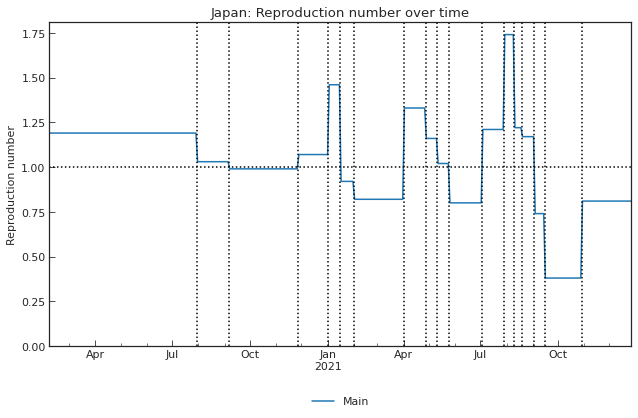

In [133]:
_ = jpn_scenario.history("Rt")

Trajectory of the number of cases and peak date will be

In [134]:
jpn_scenario.clear()
jpn_scenario.add(days=100, rho=target_rho)
df = jpn_scenario.simulate(show_figure=False)
df.loc[df["Infected"].idxmax(), "Date"]

Timestamp('2021-09-01 00:00:00')

### Change factor of $\beta$
Japan focuses on the rate of people in closed spaces/crowd. We need to avoid business offices, meeting spaces, entertainment distincts, shopping malls etc.

Here, we assume that $\beta=\tau^{-1}\rho$ is
\begin{align*}
& \beta_{(p)} = \overline{\beta}(1-p) + \beta^{\ast}p
\end{align*}
where  
$\overline{\beta}$: effective contact rate in average [1/min]  
$\beta^{\ast}$: effective contact rate in closed spaces/crowd [1/min]  
$p$: rate of people in closed spaces/crowd [-]

### Max value of $p$ to meet the goal

@ClusterJapan (expert team to prevent COVID-19 outbreak in Japan) analysed link of patients and summarized as follows. This is from [Twitter @ClusterJapan on 11Apr2020](https://twitter.com/ClusterJapan/status/1248884086581514242?s=20) (in Japanese).
* 80% of patients have less than 1 secondary infected patient
* 10% of patients have 8-12 secondary patients and they are in closed space/crowd

As my personal point of view, $\beta^{\ast}$ can be estimated as $\beta^{\ast} = 10 \times \overline{\beta}$.  
This means
\begin{align*}
& \beta_{(p)} = \overline{\beta}(1+9P)
\end{align*}

$P$ is the rate of people in the spaces where effcetive contact rate is 10 times as the average value.

With the assumption that $\overline{\beta}$ is constant,  
\begin{align*}
& \cfrac{\beta_{before}}{1+9P_{before}} = \cfrac{\beta_{after}}{1+9P_{after}}
\end{align*}
("Before" means "before the national emergency declaration on 06Apr2020.)

Then,
\begin{align*}
& \cfrac{1+9P_{after}}{1+9P_{before}} = \cfrac{\rho_{after}}{\rho_{before}}
\end{align*}

So,
\begin{align*}
& P_{after} = \frac{1}{9}\left[ \cfrac{\rho_{after}}{\rho_{before}}(1+9P_{before}) - 1 \right]
\end{align*}

$\cfrac{\rho_{after}}{\rho_{before}}$ is

In [135]:
target_rho / jpn_scenario.get("rho", name="Main", phase="last")

1.0

We can estimate $P_{before}$ with go-out table.
* Schools were closed
* 10.6% of people work remotely because
  - 5.6% of respondents work remotely (cf.1),
  - total number of respondents is 23,992,701 (cf.2),
  - 2,651,272 respondents are working in service industry (cf.2),
  - 2,128,322 respondents are medical personnel or care worker (cf.2),
  - 7,928,268 respondents are office workers or workers of logistics companies (cf.2).
  - The number of days the respondent work remotely is not known.
* As usual, 75% of people are in closed space/crowded (CC) area: this is just my point of view, I'm gathering information.
* Compared to baseline, 25% reduction was shown in Retail & recreation area: cf.3

cf.1: (In Japanese) [Report of 1st survey by Ministry of Health, Labor and Welfare & LINE Corporation](https://www.mhlw.go.jp/stf/newpage_10695.html)  
cf.2: (In Japanese) [Detailed report of 1st survey by Ministry of Health, Labor and Welfare & LINE Corporation](https://www.mhlw.go.jp/stf/newpage_10798.html)
Movility reports: [COVID-19 Community Mobility Reports in Japan on 05Apr2020](https://www.gstatic.com/covid19/mobility/2020-04-05_JP_Mobility_Report_en.pdf)

In [136]:
remote_rate = round(0.056 * 23992701 / (2651272 + 2128322 + 7928268), 3)
remote_rate

0.106

In [137]:
df = go_out("Japan")
df["School"] = 0
df["Remote"] = df["Office"] * remote_rate
df["Workplace"] = df["Office"] - df["Remote"]
df["Others_CC"] = df["Others"] * 0.75 * (1 - 0.25)
df["Others"] = df["Others"] - df["Others_CC"]
df = pd.concat([df["Portion"], df.loc[:, ~df.columns.isin(["Portion"])]], axis=1)
df = df.drop("Office", axis=1)
jpn_go_df = df.copy()
jpn_go_df

Retrieving population pyramid dataset (Japan) from https://data.worldbank.org/


,Portion,Age_first,Age_last,Period_of_life,School,Others,Age,Population,Remote,Workplace,Others_CC
0,0.026012,0,2,nursery,0,0.0000,2,2852568,0.000,0.000,0.0000
1,0.027143,3,5,nursery school,0,0.4375,5,2976538,0.000,0.000,0.5625
2,0.049302,6,10,elementary school,0,0.4375,10,5406573,0.000,0.000,0.5625
3,0.030291,11,13,middle school,0,0.4375,13,3321807,0.000,0.000,0.5625
4,0.051487,14,18,high school,0,0.4375,18,5646281,0.000,0.000,0.5625
5,0.075915,19,25,university/work,0,0.4375,25,8325118,0.318,2.682,0.5625
6,0.120151,26,35,work,0,0.4375,35,13176170,0.636,5.364,0.5625
7,0.150623,36,45,work,0,0.4375,45,16517812,0.530,4.470,0.5625
8,0.165475,46,55,work,0,0.4375,55,18146550,0.530,4.470,0.5625
9,0.140429,56,65,work,0,0.4375,65,15399883,0.530,4.470,0.5625


$P_{before}$ can be estimated as

In [138]:
df = jpn_go_df.copy()
p_before = (df[["School", "Workplace", "Others_CC"]].sum(axis=1) * df["Portion"]).sum() / 7
p_before

0.5211640508321245

\begin{align*}
& P_{after} = \frac{1}{9}\left[ \cfrac{\rho_{after}}{\rho_{before}}(1+9P_{before}) - 1 \right]
\end{align*}

To meet the goal, $P_{after}$ should be under

In [139]:
def calc_target_p(rho_before, rho_after, p_before):
    return (rho_before / rho_after * (1 + 9 * p_before) - 1) / 9

In [140]:
rho_last = jpn_scenario.get("rho", name="Main", phase="last")
target_p = calc_target_p(target_rho, rho_last, p_before)
target_p

0.5211640508321245

# Remarks<a id="9"></a>
Thank you for reading!  
Lisphilar from Japan

## Conclusion
(Will be updated)

## Acknowledgement<a id="3"></a>
### Datasets in kaggle
* The number of cases: [Novel Corona Virus 2019 Dataset](https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset)
* Total population: [covid19-global-forecasting-locations-population](https://www.kaggle.com/dgrechka/covid19-global-forecasting-locations-population/metadata)
* Population pyramid: [Population Pyramid 2019](https://www.kaggle.com/hotessy/population-pyramid-2019)
* Mesaures in each country: [COVID-19 containment and mitigation measures](https://www.kaggle.com/paultimothymooney/covid19-containment-and-mitigation-measures)
* Measures in Italy: [COVID-19 Prevention in Italy](https://www.kaggle.com/marcoferrante/covid19-prevention-in-italy)

#### Datasets created by the notebook auther
[COVID-19 dataset in Japan](https://www.kaggle.com/lisphilar/covid19-dataset-in-japan)
* The number of cases in Japan: PCR-tested, with/without symptoms, mild/severe, hospitalized or not etc.
* The number of cases at prefecture level: PCR-test, confirmed, discharged, fatal
* Basic information of each prefecture: Population, area, the number of beds

Data is from HP of Ministry of Health, Labour and Welefare, Japan:  
[Ministry of Health, Labour and Welefare HP (in Japanese)](https://www.mhlw.go.jp/)  
[Ministry of Health, Labour and Welefare HP (in English)](https://www.mhlw.go.jp/english/)  
[COVID-19 Japan 都道府県別 感染症病床数 (CC BY)](https://code4sabae.github.io/bedforinfection/)  
[Wikipedia](https://ja.wikipedia.org/wiki/)  

### Data provided by kagglers as a comment on this notebook
* The number of days persons of each age group usually go out provided by [Marco Ferrante](https://www.kaggle.com/marcoferrante)

### External resources
* Population pyramid: [PopulationPyramid.net](https://www.populationpyramid.net/) licensed under [Creative Commons license CC BY 3.0](https://creativecommons.org/licenses/by/3.0/)
* Movility report in Italy: [COVID-19 Mobility Monitoring project](https://covid19mm.github.io/) licenced under [Creative Commons license CC BY 4.0](https://creativecommons.org/licenses/by/4.0/)
* Movility reports: [Google: COVID-19 Community Mobility Reports](https://www.google.com/covid19/mobility/)
* Gomperz curve: [Jia, Lin, et al. "Prediction and analysis of Coronavirus Disease 2019." arXiv preprint arXiv:2003.05447 (2020).](https://arxiv.org/ftp/arxiv/papers/2003/2003.05447.pdf)

(In Japanese)
* Mobility: [Report of 1st survey by Ministry of Health, Labor and Welfare & LINE Corporation](https://www.mhlw.go.jp/stf/newpage_10695.html)  
* Mobility: [Detailed report of 1st survey by Ministry of Health, Labor and Welfare & LINE Corporation](https://www.mhlw.go.jp/stf/newpage_10798.html)
* @ClusterJapan (expert team to prevent COVID-19 outbreak in Japan) comments: [Twitter @ClusterJapan on 11Apr2020](https://twitter.com/ClusterJapan/status/1248884086581514242?s=20)
* Gomperz curve: [(In Japanese) ゴンペルツ曲線とは何か？（3）](https://qiita.com/BMJr/items/4e2782e8f1d3c1db6801)

### References and reading materials

#### Papers
* Basic reproduction number: [Van den Driessche, P., & Watmough, J. (2002).](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6002118/)
* Curve fitting with Logistic function and Gompertz function: [Jia, Lin, et al., 2020.](https://arxiv.org/ftp/arxiv/papers/2003/2003.05447.pdf)
* S-R place: [Balkew, Teshome Mogessie, "The SIR Model When S(t) is a Multi-Exponential Function." (2010).Electronic Theses and Dissertations.Paper 1747](https://dc.etsu.edu/cgi/viewcontent.cgi?article=3102&context=etd)
* Un-controlled clinical study of Remdesivir: [Grein, Jonathan, et al., 2020](https://www.nejm.org/doi/full/10.1056/NEJMoa2007016?query=RP)

#### KEGG
* KEGG DRUG DATABASE: [Remdesivir (USAN)](https://www.kegg.jp/dbget-bin/www_bget?dr:D11472)
* KEGG DRUG DATABASE: [Favipiravir (AVIGAN)](https://www.kegg.jp/dbget-bin/www_bget?dr:D09537)
* Medical package insert of AVIGAN (In Japanese): [KEGG database "AVIGAN"](https://www.kegg.jp/medicus-bin/japic_med?japic_code=00066852)

#### Kaggle
Curve fitting with Gamma PDF etc. by [Bill Holst](https://www.kaggle.com/wjholst). 
* [COVID-19 Growth Patterns in Critical Countries](https://www.kaggle.com/wjholst/covid-19-growth-patterns-in-critical-countries#Gaussian-Approximation-of-Active-Cases)
* [COVID-19 - Growth of Virus in Specific Countries](https://www.kaggle.com/wjholst/covid-19-growth-of-virus-in-specific-countries#Gaussian-Approximation-of-Active-Cases)
* [Prediction With a Gamma PDF](https://www.kaggle.com/wjholst/prediction-with-a-gamma-pdf)

#### YouTube
* Growth Factor: [YouTube "Exponential growth and epidemics"](https://www.youtube.com/watch?v=Kas0tIxDvrg)
* Physical distancing (social distancing): [YouTube "Simulating an epidemic"](https://www.youtube.com/watch?v=gxAaO2rsdIs)
* $\Delta$Confirmed vs. Confirmed plot: [YouTube: How To Tell If We're Beating COVID-19](https://www.youtube.com/watch?v=54XLXg4fYsc)

#### Other online resources
* Simple SIR model: [The SIR epidemic model](https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/)
* SEIR model: [Introduction to SEIR model Models](http://indico.ictp.it/event/7960/session/3/contribution/19/material/slides/)
* Basic reproduction number: [Estimating the Impact of a Pathogen via Monte Carlo Simulation](https://towardsdatascience.com/infection-modeling-part-1-87e74645568a)
* RMSLE score: [What’s the Difference Between RMSE and RMSLE?](https://medium.com/analytics-vidhya/root-mean-square-log-error-rmse-vs-rmlse-935c6cc1802a)


## Change log<a id="11"></a>

### In Feb2020
 * 13Feb2020: SIR model
 * 15Feb2020: SIR-D model
 * 22Feb2020: SIR-F model
 * 23Feb2020: Changed the dataset from 2019_ncov_data.csv to covid_19_data.csv
 * 23Feb2020: $\tau$ was fixed as "1 day" because the time format of ObservationDate is MM/DD/YYYY
 * 23Feb2020: SIR-F model with other countries
 * 23Feb2020: How to minimize the damage (Change of parameter, Vacctination)
 * 24Feb2020: Use $\tau$ again

### In Mar2020
 * 01Mar2020: $\tau$ definition was changed. $1\leq \tau \mathrm{[hour]} \leq 24$ $\to$ $1\leq \tau \mathrm{[min]} \leq 1440$ 
 * 01Mar2020: Added "Test of hyperparameter optimization using example data" in SIR model section
 * 02Mar2020: Analysis of Linelist (estimation of Effective contact/Recovery/Death rate using case reports)
 * 03Mar2020: Trend analysis
 * 03Mar2020: Update estimator error function; Exponential Weighted Moving Average (span=14days) of |observed - estimated|
 * 04Mar2020: "Analysis of Linelist" was moved to [EDA of linelist](https://www.kaggle.com/lisphilar/eda-of-linelist?scriptVersionId=29640733#Remarks)
 * 04Mar2020: Data in Hubei and China will be analysed in another notebook. Please refer to [Data in China with SIR model](https://www.kaggle.com/lisphilar/data-in-china-with-sir-model?scriptVersionId=29646940).
 * 06Mar2020: Random seed was fixed as 2019
 * 06Mar2020: Update estimator error function; Weighted Average of |Exponential Weighted Moving Average (span=14days) of observed - estimated|
 * 07Mar2020: Update estimator error function; Total population $\times$ Wighted Average of |observed - estimated| with step number t
 * 07Mar2020: Priorities of variables in estimator error function was set as $(x, y, z, w) = (1, 10, 10, 1)$ in SIR-F model.
 * 09Mar2020: Update estimator error function; $(\mathrm{Population})^2$ $\times$ (Wighted Average of |observed - estimated|/[observed $\times$ Population + 1] with step number t)
 * 09Mar2020: Priorities of variables in estimator error function were set as $(x, y, z, w) = (1, 10, 10, 2)$ in SIR-F model.
 * 11Mar2020: Update model.param_dict(); each parametor range was limited to 30%-70% quantiles of the estimated values ($\frac{\mathrm{d}z}{\mathrm{d}t}\left(\frac{1}{y}\right)$ for $\sigma$) of training dataset.
 * 12Mar2020: Update model.param_dict(); each parameter range was limited to 5%-95% quantiles
 * 12Mar2020: Detailed scenario analysis. Thank you, Marco Ferrante!
 * 13Mar2020: Update model.param_dict(); each parameter range was limited to 0%-100% quantiles
 * 13Mar2020: Update "Detailed scenario analysis" > "Real factors of effective contact rate $\beta$"
 * 14Mar2020: Update model.param_dict(); rho/sigma range was limited to 30%-70% quantiles of their estimated values
 * 14Mar2020: Applied trend analysis on country level data to use only a part of records for estimation
 * 14Mar2020: Recovered without confirmation was added to "Real factors of effective contact rate $\beta$"
 * 15Mar2020: Merge "How to minimize the damage (Change of parameter, Vacctination)" with "Scenario analysis" section
 * 15Mar2020: Update Estimator, int to np.int. Thank you Enrico Papalini!
 * 15Mar2020: Update Estimator, some parameters can be fixed. Some of SIR parameters can be applied to SIR-F model.
 * 17Mar2020: The number of exposed cases and waiting cases
 * 17Mar2020: Update Scenario analysis
 * 18Mar2020: Scenario analysis in Italy
 * 19Mar2020: Estimation of new drugs effect in "Scenario analysis in Italy" section
 * 29Mar2020: Grouping of countries by growth factor
 * 29Mar2020: Update "Scenario in Italy" section to include confirmed national lockdown effect

### In Apr2020
 * 05Apr2020: Update simulation() fucntion, dense_ouput=False
 * 05Apr2020: Create Scenario() class
 * 06Apr2020: Update Scenario() class to reduce running time
 * 11Apr2020: Italy entered 4th phase
 * 11Apr2020: Add "How to make way by 31May2020 for the number of cases peaking out" in Japan
 * 13Apr2020: "excluded_places" was used for SEWIR-F and showed incorrected graph in the previous versions. Replaced with "places"
 * 17Apr2020: Prepare the dataset in Japan
 * 18Apr2020: Update RMSLE score fucntion of Estimator, $\ln(x)$ to $log_{10}(x)$
 * 18Apr2020: Add explanation of accuracy index of hyperparameter estimation
 * 18Apr2020: Japan entered 3rd phase
 * 18Apr2020: Data in "Expalanation of concept part" was changed from actual data to example data
 * 27Apr2020: "S-R trend analysis" section
 * 28Apr2020: In scenario analysis, Exponential trend analysis was replaced with S-R trend analysis
 * 28Apr2020: Add scenario analysis in India and USA
 * 29Apr2020: Add scenario analysis in New Zealand

### In May2020
 * 01May2020: Change assumed parameter values in "Factors of model parameters" section
 * 01May2020: Fix bag of SIR-FV model, calculation of Vaccinated (Immuned)
 * 03May2020: Random seed was fixed in S-R trend analysis
 * 03May2020: Error function of S-R trend anaysis was changed from squared error to weghtend squared error with day numbers
 * 03May2020: Fix bag of Scenario class, the start point of prediction
 * 03May2020: The result of un-controlled clinical study of Remdesivir was applied to scenario analysis in Italy
 * 06May2020: Error function of S-R trend anaysis was changed from weghtend squared error to squared error
 * 06May2020: Update Trend class, S-R trend in recent days will be valued, the last change point will be searched at first
 * 09May2020: Published the functions as a Python package
 * 30May2020: Finished refactoring of codes in the package

### In Jun2020
 * 17Jun2020: Released version 2.2.0 of CovsirPhy and ODE simulation will be done with tau-free dataset (time step [-] and ODE variables [persons])
 * 17Jun2020: Restricted tau value [min] as to the divisors of 1440 [min]
 * 28Jun2020: Revised definition of SEWIR-F $R_0$ value
 * 28Jun2020: Registered CovsirPhy v2.3.0 to PyPI

### In Jul2020
 * 08Jul2020: Update with CovsirPhy v2.4.1
 * 11Jul2020: Update with CovsirPhy v2.4.2
 * 14Jul2020: Update with CovsirPhy v2.5.0 and v2.5.1
 * 15Jul2020: Update with CovsirPhy v2.5.2
 * 16Jul2020: Update with CovsirPhy v2.5.3
 * 18Jul2020: Update with CovsirPhy v2.5.4
 * 25Jul2020: Update with CovsirPhy v2.6.0

### In Aug2020
 * 16Aug2020: Update with CovsirPhy v2.7.0
 * 21Aug2020: Update with CovsirPhy v2.7.1
 * 21Aug2020: Update with CovsirPhy v2.7.3

### In Sep2020
 * 04Sep2020: Update with CovsirPhy v2.8.1
 * 08Sep2020: Update with CovsirPhy v2.8.2
 * 20Sep2020: Update with CovsirPhy v2.8.3

### In Oct2020
 * 20Oct2020: Update with CovsirPhy v2.9.0
 * 24Oct2020: Update with CovsirPhy v2.9.1
 * 24Oct2020: Remove monitoring chapter because no updates are available for the Kaggle dataset
 * 26Oct2020: Use COVID-19 Data Hub as the data source in this Kaggle notebook
 * 28Oct2020: Use ./output/kaggle/working/kaggle/input directory will be used to save external datasets
 * 28Oct2020: Add how to use covsirphy.DataLoader.japan()

### In Nov2020


 * 08Nov2020: Update with CovsirPhy v2.10.0
 * 20Nov2020: Update with CovsirPhy v2.11.0
 * 28Nov2020: Update with CovsirPhy v2.12.0

### In Dec2021

 * 13Dec2020: Update with CovsirPhy v2.13.0
 * 13Dec2020: Update model descriptions
 * 28Dec2020: Use covsirphy.DataLoader.pyramid()